# Проект: классификация

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [3]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [4]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
# ваш код

# Общая информация о DataFrame
print("Общая информация о данных:")
print(f"Размер DataFrame: {df.shape}")
print(f"Столбцы: {list(df.columns)}")
print()

# Проверка пропусков по столбцам
print("Количество пропусков по столбцам:")
missing_values = df.isnull().sum()
print(missing_values)
print()

# Процент пропусков по столбцам
print("Процент пропусков по столбцам:")
missing_percent = (df.isnull().sum() / len(df)) * 100
for col, percent in missing_percent.items():
    if percent > 0:
        print(f"{col}: {percent:.2f}%")
print()

# Общее количество пропусков
total_missing = df.isnull().sum().sum()
print(f"Общее количество пропусков: {total_missing}")

# Столбцы с пропусками
columns_with_missing = df.columns[df.isnull().any()].tolist()
print(f"Столбцы с пропусками: {columns_with_missing}")

Общая информация о данных:
Размер DataFrame: (11162, 17)
Столбцы: ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'deposit']

Количество пропусков по столбцам:
age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

Процент пропусков по столбцам:
balance: 0.22%

Общее количество пропусков: 25
Столбцы с пропусками: ['balance']


### Задание 2

In [5]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
# ваш код

# Проверяем стандартные пропуски в столбце job
print("Стандартные пропуски (NaN) в столбце 'job':")
print(f"Количество NaN: {df['job'].isnull().sum()}")
print()

# Смотрим на уникальные значения в столбце job
print("Уникальные значения в столбце 'job':")
unique_values = df['job'].unique()
print(f"Всего уникальных значений: {len(unique_values)}")
print("Список значений:")
for value in sorted(unique_values):
    print(f"  '{value}'")
print()

# Подсчитываем частоту каждого значения
print("Частота значений в столбце 'job':")
value_counts = df['job'].value_counts()
print(value_counts)
print()

# Ищем потенциальные скрытые пропуски
potential_missing = ['unknown', 'missing', 'na', 'n/a', 'none', 'null', '', ' ', 'undefined', 'other']
print("Проверка на потенциальные скрытые пропуски:")
for missing_val in potential_missing:
    count = (df['job'] == missing_val).sum()
    if count > 0:
        print(f"  '{missing_val}': {count} записей")

# Проверяем на пустые строки или строки из пробелов
empty_strings = (df['job'] == '').sum()
whitespace_strings = (df['job'].str.strip() == '').sum()
print(f"\nПустые строки: {empty_strings}")
print(f"Строки из пробелов: {whitespace_strings}")

Стандартные пропуски (NaN) в столбце 'job':
Количество NaN: 0

Уникальные значения в столбце 'job':
Всего уникальных значений: 12
Список значений:
  'admin.'
  'blue-collar'
  'entrepreneur'
  'housemaid'
  'management'
  'retired'
  'self-employed'
  'services'
  'student'
  'technician'
  'unemployed'
  'unknown'

Частота значений в столбце 'job':
job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64

Проверка на потенциальные скрытые пропуски:
  'unknown': 70 записей

Пустые строки: 0
Строки из пробелов: 0


### Задание 3

In [6]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)

import re

# Создаем копию для обработки
df['balance_clean'] = df['balance'].astype(str)

# Применяем регулярные выражения для очистки данных
# 1. Удаляем лишние пробелы в начале и конце
df['balance_clean'] = df['balance_clean'].str.strip()

# 2. Заменяем запятые на точки (для европейского формата чисел)
df['balance_clean'] = df['balance_clean'].str.replace(',', '.', regex=False)

# 3. Удаляем все символы кроме цифр, точек
df['balance_clean'] = df['balance_clean'].apply(lambda x: re.sub(r'[^\d.-]', '', str(x)))

# 4. Исправляем случаи с несколькими точками - оставляем только первую
df['balance_clean'] = df['balance_clean'].apply(lambda x: re.sub(r'\.(?=.*\.)', '', str(x)))

# 5. Убираем знаки минус не в начале числа
df['balance_clean'] = df['balance_clean'].apply(lambda x: re.sub(r'(?<!^)-', '', str(x)))

# Преобразуем в числовой формат
df['balance'] = pd.to_numeric(df['balance_clean'], errors='coerce')

# Удаляем временный столбец
df.drop('balance_clean', axis=1, inplace=True)

# Проверяем результат
df['balance'].describe()

count    11137.000000
mean      1529.129029
std       3228.114892
min      -6847.000000
25%        123.000000
50%        550.000000
75%       1708.000000
max      81204.000000
Name: balance, dtype: float64

### Задание 4

In [7]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
# ваш код

# Проверим количество пропусков до обработки
print("Информация о пропусках в столбце 'balance' до обработки:")
print(f"Количество пропусков: {df['balance'].isnull().sum()}")
print()

# Вычислим медианное значение (только для непропущенных значений)
median_balance = df['balance'].median()
print(f"Медианное значение столбца 'balance': {median_balance}")
print()

# Заменяем пропуски на медианное значение
df['balance'].fillna(median_balance, inplace=True)

# Проверим результат после обработки
print("Информация после обработки пропусков:")
print(f"Количество пропусков: {df['balance'].isnull().sum()}")
print(f"Количество валидных значений: {df['balance'].notnull().sum()}")
print()

# Покажем описательную статистику после заполнения
print("Описательная статистика после заполнения пропусков:")
print(df['balance'].describe())

Информация о пропусках в столбце 'balance' до обработки:
Количество пропусков: 25

Медианное значение столбца 'balance': 550.0

Информация после обработки пропусков:
Количество пропусков: 0
Количество валидных значений: 11162

Описательная статистика после заполнения пропусков:
count    11162.000000
mean      1526.936033
std       3224.829691
min      -6847.000000
25%        123.000000
50%        550.000000
75%       1699.000000
max      81204.000000
Name: balance, dtype: float64


### Задание 5

In [8]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
# ваш код

# скрытые пропуски в виде 'unknown', заменим их на NaN
# Сначала для столбца 'job'
if 'unknown' in df['job'].values:
    df['job'] = df['job'].replace('unknown', np.nan)
    print(f"Пропуски в 'job' после замены 'unknown' на NaN: {df['job'].isnull().sum()}")

# Для столбца 'education' 
if 'unknown' in df['education'].values:
    df['education'] = df['education'].replace('unknown', np.nan)
    print(f"Пропуски в 'education' после замены 'unknown' на NaN: {df['education'].isnull().sum()}")

print()

# Найдем модальные значения (наиболее часто встречающиеся)
mode_job = df['job'].mode()[0]  # mode() возвращает Series, берем первый элемент
mode_education = df['education'].mode()[0]

print("Модальные значения:")
print(f"Мода для 'job': {mode_job}")
print(f"Мода для 'education': {mode_education}")
print()

# Заменяем пропуски на модальные значения
df['job'].fillna(mode_job, inplace=True)
df['education'].fillna(mode_education, inplace=True)

# Проверяем результат
print("Информация после обработки пропусков:")
print(f"Пропуски в 'job': {df['job'].isnull().sum()}")
print(f"Пропуски в 'education': {df['education'].isnull().sum()}")
print()

# Показываем частоту значений после обработки
print("Частота значений в 'job' (топ-5):")
print(df['job'].value_counts().head())
print()
print("Частота значений в 'education':")
print(df['education'].value_counts())

print()
# Дополнительно: средний balance для людей с job == 'management' И education == 'secondary'
management_secondary_balance_mean = df[(df['job'] == 'management') & (df['education'] == 'secondary')]['balance'].mean()
print(f"Средний balance для job == 'management' И education == 'secondary': {management_secondary_balance_mean:.2f}")

Пропуски в 'job' после замены 'unknown' на NaN: 70
Пропуски в 'education' после замены 'unknown' на NaN: 497

Модальные значения:
Мода для 'job': management
Мода для 'education': secondary

Информация после обработки пропусков:
Пропуски в 'job': 0
Пропуски в 'education': 0

Частота значений в 'job' (топ-5):
job
management     2636
blue-collar    1944
technician     1823
admin.         1334
services        923
Name: count, dtype: int64

Частота значений в 'education':
education
secondary    5973
tertiary     3689
primary      1500
Name: count, dtype: int64

Средний balance для job == 'management' И education == 'secondary': 1598.88


### Задание 6

In [9]:
# удалите все выбросы для признака balance
# ваш код

# Метод Тьюки для поиска выбросов
print("Анализ выбросов для признака 'balance' методом Тьюки")
print("=" * 60)

# Вычисляем квартили и межквартильный размах (IQR)
Q1 = df['balance'].quantile(0.25)  # Нижний квартиль (25-й процентиль)
Q3 = df['balance'].quantile(0.75)  # Верхний квартиль (75-й процентиль)
IQR = Q3 - Q1  # Межквартильный размах

print(f"Первый квартиль (Q1): {Q1:.2f}")
print(f"Третий квартиль (Q3): {Q3:.2f}")
print(f"Межквартильный размах (IQR): {IQR:.2f}")
print()

# Вычисляем границы по методу Тьюки (1.5 * IQR)
lower_bound = Q1 - 1.5 * IQR  # Нижняя граница
upper_bound = Q3 + 1.5 * IQR  # Верхняя граница

print("Границы для определения выбросов:")
print(f"Нижняя граница: {lower_bound:.2f} (округленно: {round(lower_bound)})")
print(f"Верхняя граница: {upper_bound:.2f} (округленно: {round(upper_bound)})")
print()

# Подсчитываем количество выбросов
outliers_mask = (df['balance'] < lower_bound) | (df['balance'] > upper_bound)
outliers_count = outliers_mask.sum()
total_records = len(df)

print(f"Количество выбросов: {outliers_count} из {total_records} записей ({outliers_count/total_records*100:.2f}%)")
print()

# Показываем статистику до удаления выбросов
print("Статистика balance ДО удаления выбросов:")
print(df['balance'].describe())
print()

# Удаляем выбросы
df_cleaned = df[~outliers_mask].copy()
print(f"Размер данных до удаления выбросов: {df.shape}")
print(f"Размер данных после удаления выбросов: {df_cleaned.shape}")
print(f"Удалено записей: {df.shape[0] - df_cleaned.shape[0]}")
print()

# Показываем статистику после удаления выбросов
print("Статистика balance ПОСЛЕ удаления выбросов:")
print(df_cleaned['balance'].describe())
print()

# Обновляем основной DataFrame
df = df_cleaned.copy()

print("=" * 60)
print("ОТВЕТ:")
print(f"Нижняя граница (округленно): {round(lower_bound)}")
print(f"Верхняя граница (округленно): {round(upper_bound)}")
print("=" * 60)

Анализ выбросов для признака 'balance' методом Тьюки
Первый квартиль (Q1): 123.00
Третий квартиль (Q3): 1699.00
Межквартильный размах (IQR): 1576.00

Границы для определения выбросов:
Нижняя граница: -2241.00 (округленно: -2241)
Верхняя граница: 4063.00 (округленно: 4063)

Количество выбросов: 1057 из 11162 записей (9.47%)

Статистика balance ДО удаления выбросов:
count    11162.000000
mean      1526.936033
std       3224.829691
min      -6847.000000
25%        123.000000
50%        550.000000
75%       1699.000000
max      81204.000000
Name: balance, dtype: float64

Размер данных до удаления выбросов: (11162, 17)
Размер данных после удаления выбросов: (10105, 17)
Удалено записей: 1057

Статистика balance ПОСЛЕ удаления выбросов:
count    10105.000000
mean       807.653538
std        994.151966
min      -2049.000000
25%         95.000000
50%        445.000000
75%       1227.000000
max       4063.000000
Name: balance, dtype: float64

ОТВЕТ:
Нижняя граница (округленно): -2241
Верхняя гра

## Часть 2:  Разведывательный анализ

### Задание 1

Анализ сбалансированности классов в переменной 'deposit'
Количество записей по классам:
deposit
no     5424
yes    4681
Name: count, dtype: int64

Процентное соотношение классов:
no: 53.68%
yes: 46.32%

Соотношение мажоритарного к миноритарному классу: 1.16:1
✅ Данные относительно сбалансированы.



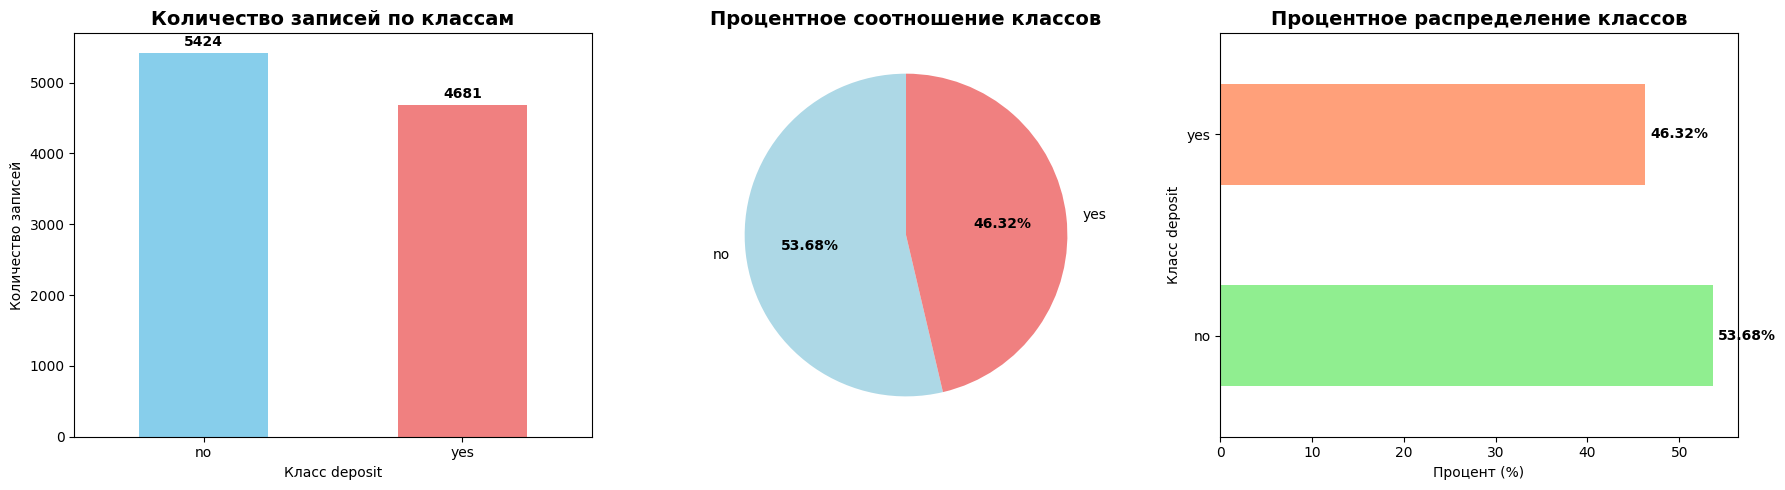


Дополнительная статистика:
Общее количество записей: 10105
Разность между классами: 743 записей
Коэффициент несбалансированности: 1.159


In [10]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
# ваш код

# Анализ соотношения классов в целевой переменной 'deposit'
print("Анализ сбалансированности классов в переменной 'deposit'")
print("=" * 60)

# Подсчитываем количество записей для каждого класса
class_counts = df['deposit'].value_counts()
print("Количество записей по классам:")
print(class_counts)
print()

# Вычисляем процентное соотношение
class_percentage = df['deposit'].value_counts(normalize=True) * 100
print("Процентное соотношение классов:")
for class_label, percentage in class_percentage.items():
    print(f"{class_label}: {percentage:.2f}%")
print()

# Оценка сбалансированности
minority_class_percentage = min(class_percentage)
majority_class_percentage = max(class_percentage)
imbalance_ratio = majority_class_percentage / minority_class_percentage

print(f"Соотношение мажоритарного к миноритарному классу: {imbalance_ratio:.2f}:1")

if imbalance_ratio > 3:
    print("⚠️  ДАННЫЕ НЕСБАЛАНСИРОВАНЫ! Рекомендуется применить методы балансировки.")
elif imbalance_ratio > 1.5:
    print("⚠️  Данные умеренно несбалансированы. Стоит рассмотреть методы балансировки.")
else:
    print("✅ Данные относительно сбалансированы.")

print()

# Создаем визуализации
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Столбчатая диаграмма
class_counts.plot(kind='bar', ax=axes[0], color=['skyblue', 'lightcoral'])
axes[0].set_title('Количество записей по классам', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Класс deposit')
axes[0].set_ylabel('Количество записей')
axes[0].tick_params(axis='x', rotation=0)

# Добавляем значения на столбцы
for i, v in enumerate(class_counts.values):
    axes[0].text(i, v + max(class_counts.values) * 0.01, str(v), 
                ha='center', va='bottom', fontweight='bold')

# 2. Круговая диаграмма
colors = ['lightblue', 'lightcoral']
wedges, texts, autotexts = axes[1].pie(class_counts.values, 
                                      labels=class_counts.index,
                                      autopct='%1.2f%%',
                                      colors=colors,
                                      startangle=90)
axes[1].set_title('Процентное соотношение классов', fontsize=14, fontweight='bold')

# Делаем текст на диаграмме более читаемым
for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontweight('bold')

# 3. Горизонтальная столбчатая диаграмма с процентами
class_percentage.plot(kind='barh', ax=axes[2], color=['lightgreen', 'lightsalmon'])
axes[2].set_title('Процентное распределение классов', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Процент (%)')
axes[2].set_ylabel('Класс deposit')

# Добавляем значения на столбцы
for i, v in enumerate(class_percentage.values):
    axes[2].text(v + max(class_percentage.values) * 0.01, i, f'{v:.2f}%', 
                ha='left', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Дополнительная информация
print("\nДополнительная статистика:")
print(f"Общее количество записей: {len(df)}")
print(f"Разность между классами: {abs(class_counts.iloc[0] - class_counts.iloc[1])} записей")
print(f"Коэффициент несбалансированности: {imbalance_ratio:.3f}")


### Задания 2 и 3

Количественные переменные: ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

ОСНОВНЫЕ ОПИСАТЕЛЬНЫЕ СТАТИСТИКИ:
            age   balance       day  duration  campaign     pdays  previous
count  10105.00  10105.00  10105.00  10105.00  10105.00  10105.00  10105.00
mean      40.90    807.65     15.59    368.74      2.52     51.32      0.82
std       11.73    994.15      8.44    346.65      2.71    109.64      2.24
min       18.00  -2049.00      1.00      2.00      1.00     -1.00      0.00
25%       32.00     95.00      8.00    137.00      1.00     -1.00      0.00
50%       38.00    445.00     15.00    252.00      2.00     -1.00      0.00
75%       48.00   1227.00     22.00    490.00      3.00      2.00      1.00
max       95.00   4063.00     31.00   3881.00     43.00    854.00     58.00

ПОДРОБНЫЙ АНАЛИЗ ПО КАЖДОЙ ПЕРЕМЕННОЙ:

📊 ПЕРЕМЕННАЯ: AGE
--------------------------------------------------
📈 Меры центральной тенденции:
   • Среднее: 40.90
   • Медиана: 38.00
   

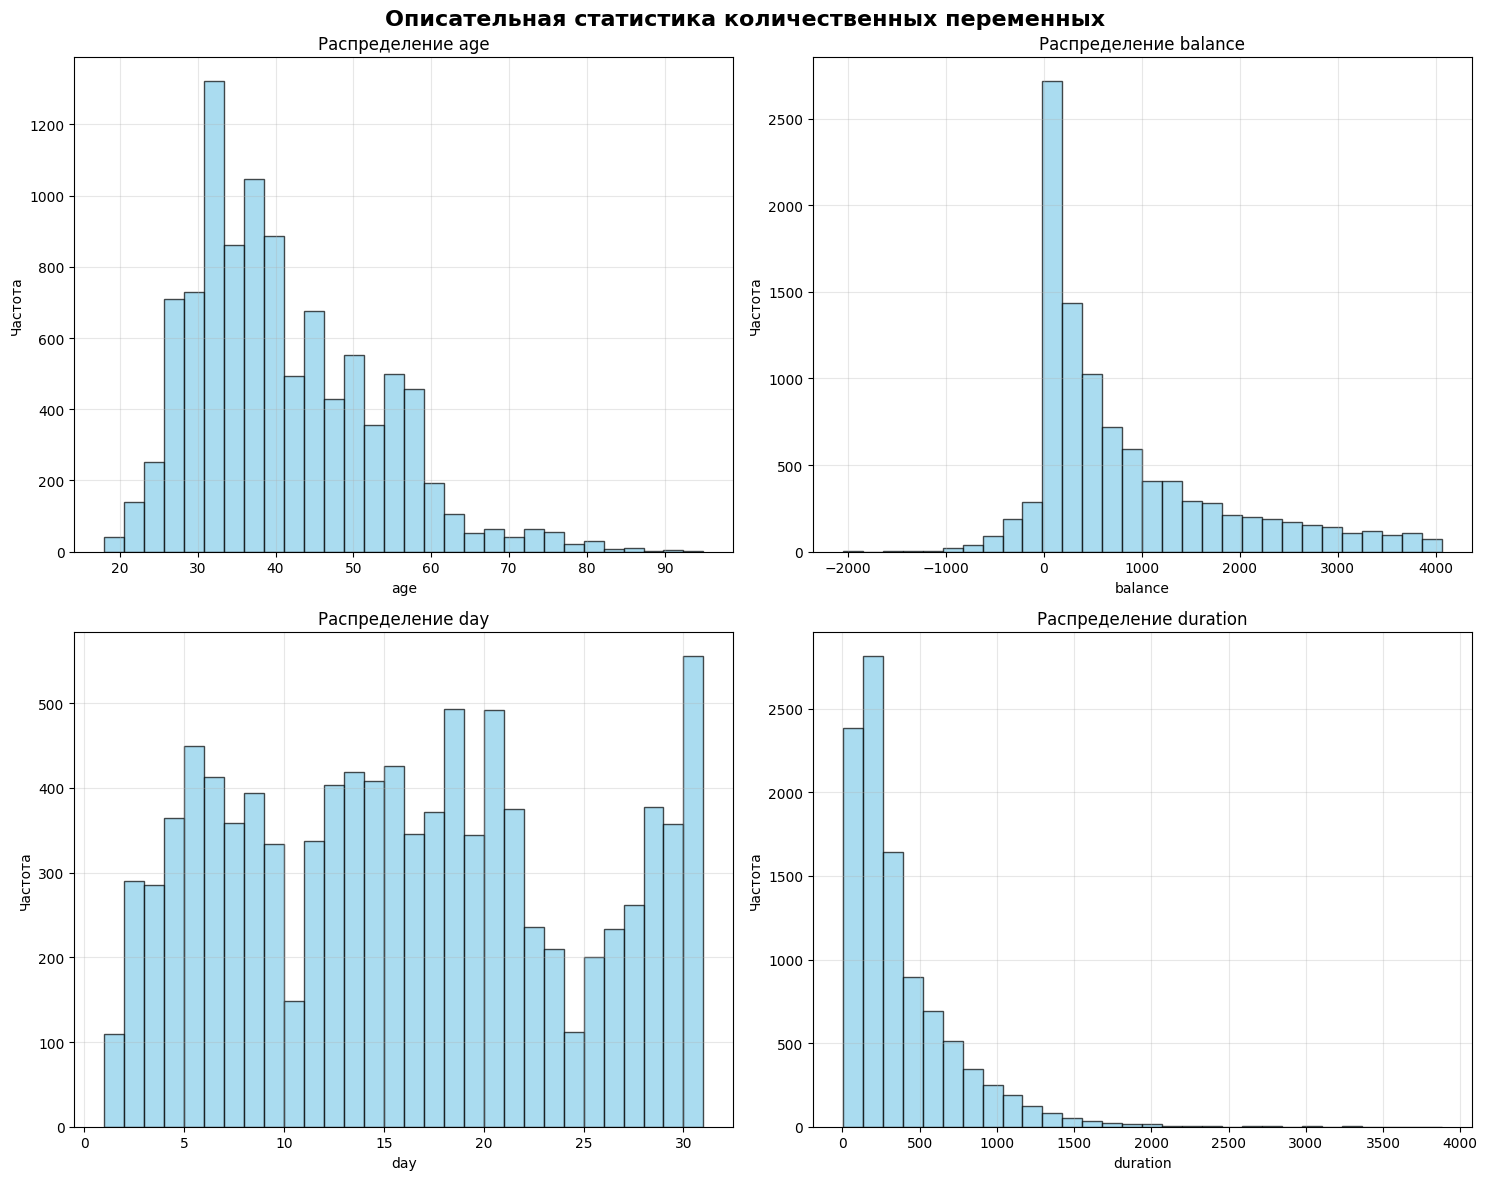

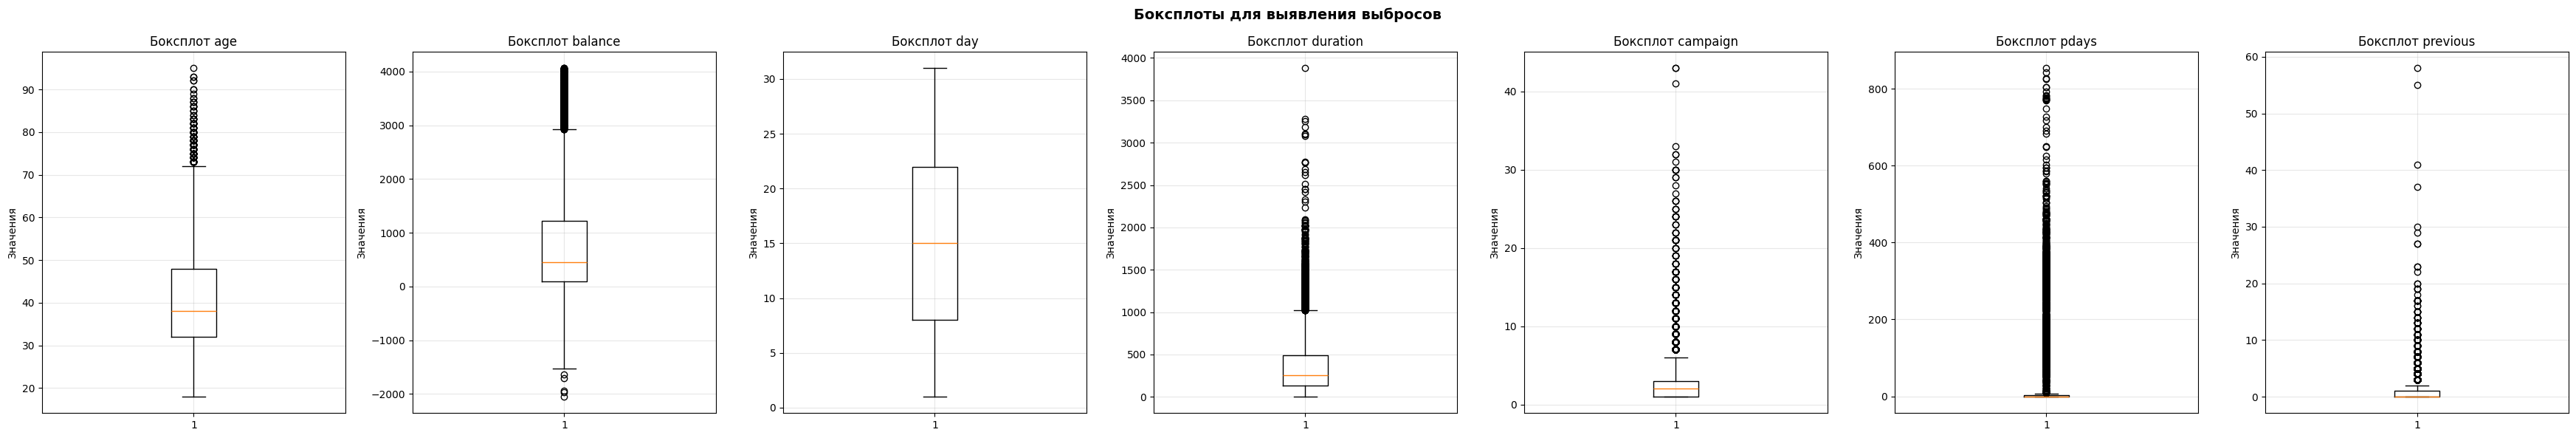

In [11]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
#ваш код

# Определяем количественные переменные
numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
print(f"Количественные переменные: {numeric_columns}")
print()

# Основные описательные статистики
desc_stats = df[numeric_columns].describe()
print("ОСНОВНЫЕ ОПИСАТЕЛЬНЫЕ СТАТИСТИКИ:")
print(desc_stats.round(2))
print()

# Дополнительные меры для каждой переменной
print("ПОДРОБНЫЙ АНАЛИЗ ПО КАЖДОЙ ПЕРЕМЕННОЙ:")
print("=" * 80)

for col in numeric_columns:
    print(f"\n📊 ПЕРЕМЕННАЯ: {col.upper()}")
    print("-" * 50)
    
    data = df[col]
    
    # Основные статистики
    mean_val = data.mean()
    median_val = data.median()
    mode_val = data.mode().iloc[0] if len(data.mode()) > 0 else "Нет моды"
    std_val = data.std()
    var_val = data.var()
    min_val = data.min()
    max_val = data.max()
    range_val = max_val - min_val
    
    # Квартили и межквартильный размах
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    
    # Коэффициент вариации
    cv = (std_val / mean_val) * 100 if mean_val != 0 else 0
    
    # Асимметрия и эксцесс
    skewness = data.skew()
    kurtosis = data.kurtosis()
    
    print(f"📈 Меры центральной тенденции:")
    print(f"   • Среднее: {mean_val:.2f}")
    print(f"   • Медиана: {median_val:.2f}")
    print(f"   • Мода: {mode_val}")
    
    print(f"\n📏 Меры разброса:")
    print(f"   • Стандартное отклонение: {std_val:.2f}")
    print(f"   • Дисперсия: {var_val:.2f}")
    print(f"   • Размах: {range_val:.2f} (от {min_val:.2f} до {max_val:.2f})")
    print(f"   • Межквартильный размах (IQR): {iqr:.2f}")
    print(f"   • Коэффициент вариации: {cv:.2f}%")
    
    print(f"\n📊 Распределение:")
    print(f"   • Асимметрия (skewness): {skewness:.3f}")
    print(f"   • Эксцесс (kurtosis): {kurtosis:.3f}")
    
    # Интерпретация асимметрии
    if abs(skewness) < 0.5:
        skew_interp = "практически симметричное"
    elif skewness > 0.5:
        skew_interp = "правосторонняя асимметрия (длинный правый хвост)"
    else:
        skew_interp = "левосторонняя асимметрия (длинный левый хвост)"
    
    # Интерпретация эксцесса
    if abs(kurtosis) < 0.5:
        kurt_interp = "нормальная островершинность"
    elif kurtosis > 0.5:
        kurt_interp = "высокая островершинность (толстые хвосты)"
    else:
        kurt_interp = "низкая островершинность (тонкие хвосты)"
    
    print(f"\n💡 Интерпретация распределения:")
    print(f"   • {skew_interp}")
    print(f"   • {kurt_interp}")
    
    # Анализ вариативности
    print(f"\n🔍 Анализ вариативности:")
    if cv < 15:
        var_level = "низкая"
    elif cv < 35:
        var_level = "умеренная"
    else:
        var_level = "высокая"
    print(f"   • Вариативность данных: {var_level} ({cv:.1f}%)")
    
    # Сравнение мер центральной тенденции
    print(f"\n⚖️ Сравнение мер центральной тенденции:")
    diff_mean_median = abs(mean_val - median_val)
    if diff_mean_median / std_val < 0.2:
        central_tendency = "Среднее ≈ медиана → симметричное распределение"
    elif mean_val > median_val:
        central_tendency = "Среднее > медиана → возможны выбросы справа (большие значения)"
    else:
        central_tendency = "Среднее < медиана → возможны выбросы слева (малые значения)"
    print(f"   • {central_tendency}")
    
    # Потенциальные выбросы по правилу 3 сигм
    lower_3sigma = mean_val - 3 * std_val
    upper_3sigma = mean_val + 3 * std_val
    outliers_3sigma = ((data < lower_3sigma) | (data > upper_3sigma)).sum()
    
    print(f"\n🚨 Потенциальные выбросы (правило 3σ):")
    print(f"   • Границы: [{lower_3sigma:.2f}, {upper_3sigma:.2f}]")
    print(f"   • Количество потенциальных выбросов: {outliers_3sigma}")
    
    print("-" * 50)

# Корреляционный анализ
print(f"\n\n📈 КОРРЕЛЯЦИОННЫЙ АНАЛИЗ")
print("=" * 50)
correlation_matrix = df[numeric_columns].corr()
print("Матрица корреляций:")
print(correlation_matrix.round(3))

# Визуализация
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Описательная статистика количественных переменных', fontsize=16, fontweight='bold')

# 1. Гистограммы
for i, col in enumerate(numeric_columns):
    row = i // 2
    col_idx = i % 2
    if i < 4:  # максимум 4 графика
        axes[row, col_idx].hist(df[col], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
        axes[row, col_idx].set_title(f'Распределение {col}')
        axes[row, col_idx].set_xlabel(col)
        axes[row, col_idx].set_ylabel('Частота')
        axes[row, col_idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Боксплоты для выявления выбросов
fig, axes = plt.subplots(1, len(numeric_columns), figsize=(5*len(numeric_columns), 6))
if len(numeric_columns) == 1:
    axes = [axes]

for i, col in enumerate(numeric_columns):
    axes[i].boxplot(df[col])
    axes[i].set_title(f'Боксплот {col}')
    axes[i].set_ylabel('Значения')
    axes[i].grid(True, alpha=0.3)

plt.suptitle('Боксплоты для выявления выбросов', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### Задания 4 и 5

Категориальные переменные: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'deposit']

ПОДРОБНЫЙ АНАЛИЗ КАТЕГОРИАЛЬНЫХ ПЕРЕМЕННЫХ:

📊 ПЕРЕМЕННАЯ: JOB
------------------------------------------------------------
📈 Основная статистика:
   • Общее количество записей: 10105
   • Количество уникальных значений: 11
   • Наиболее частое значение (мода): management

📊 Частотное распределение:
Значение             Количество   Процент   
---------------------------------------------
management           2315         22.91%
blue-collar          1807         17.88%
technician           1638         16.21%
admin.               1246         12.33%
services             868          8.59%
retired              663          6.56%
self-employed        358          3.54%
unemployed           332          3.29%
student              326          3.23%
entrepreneur         300          2.97%
housemaid            252          2.49%

💡 Интерпретация переменной 'jo

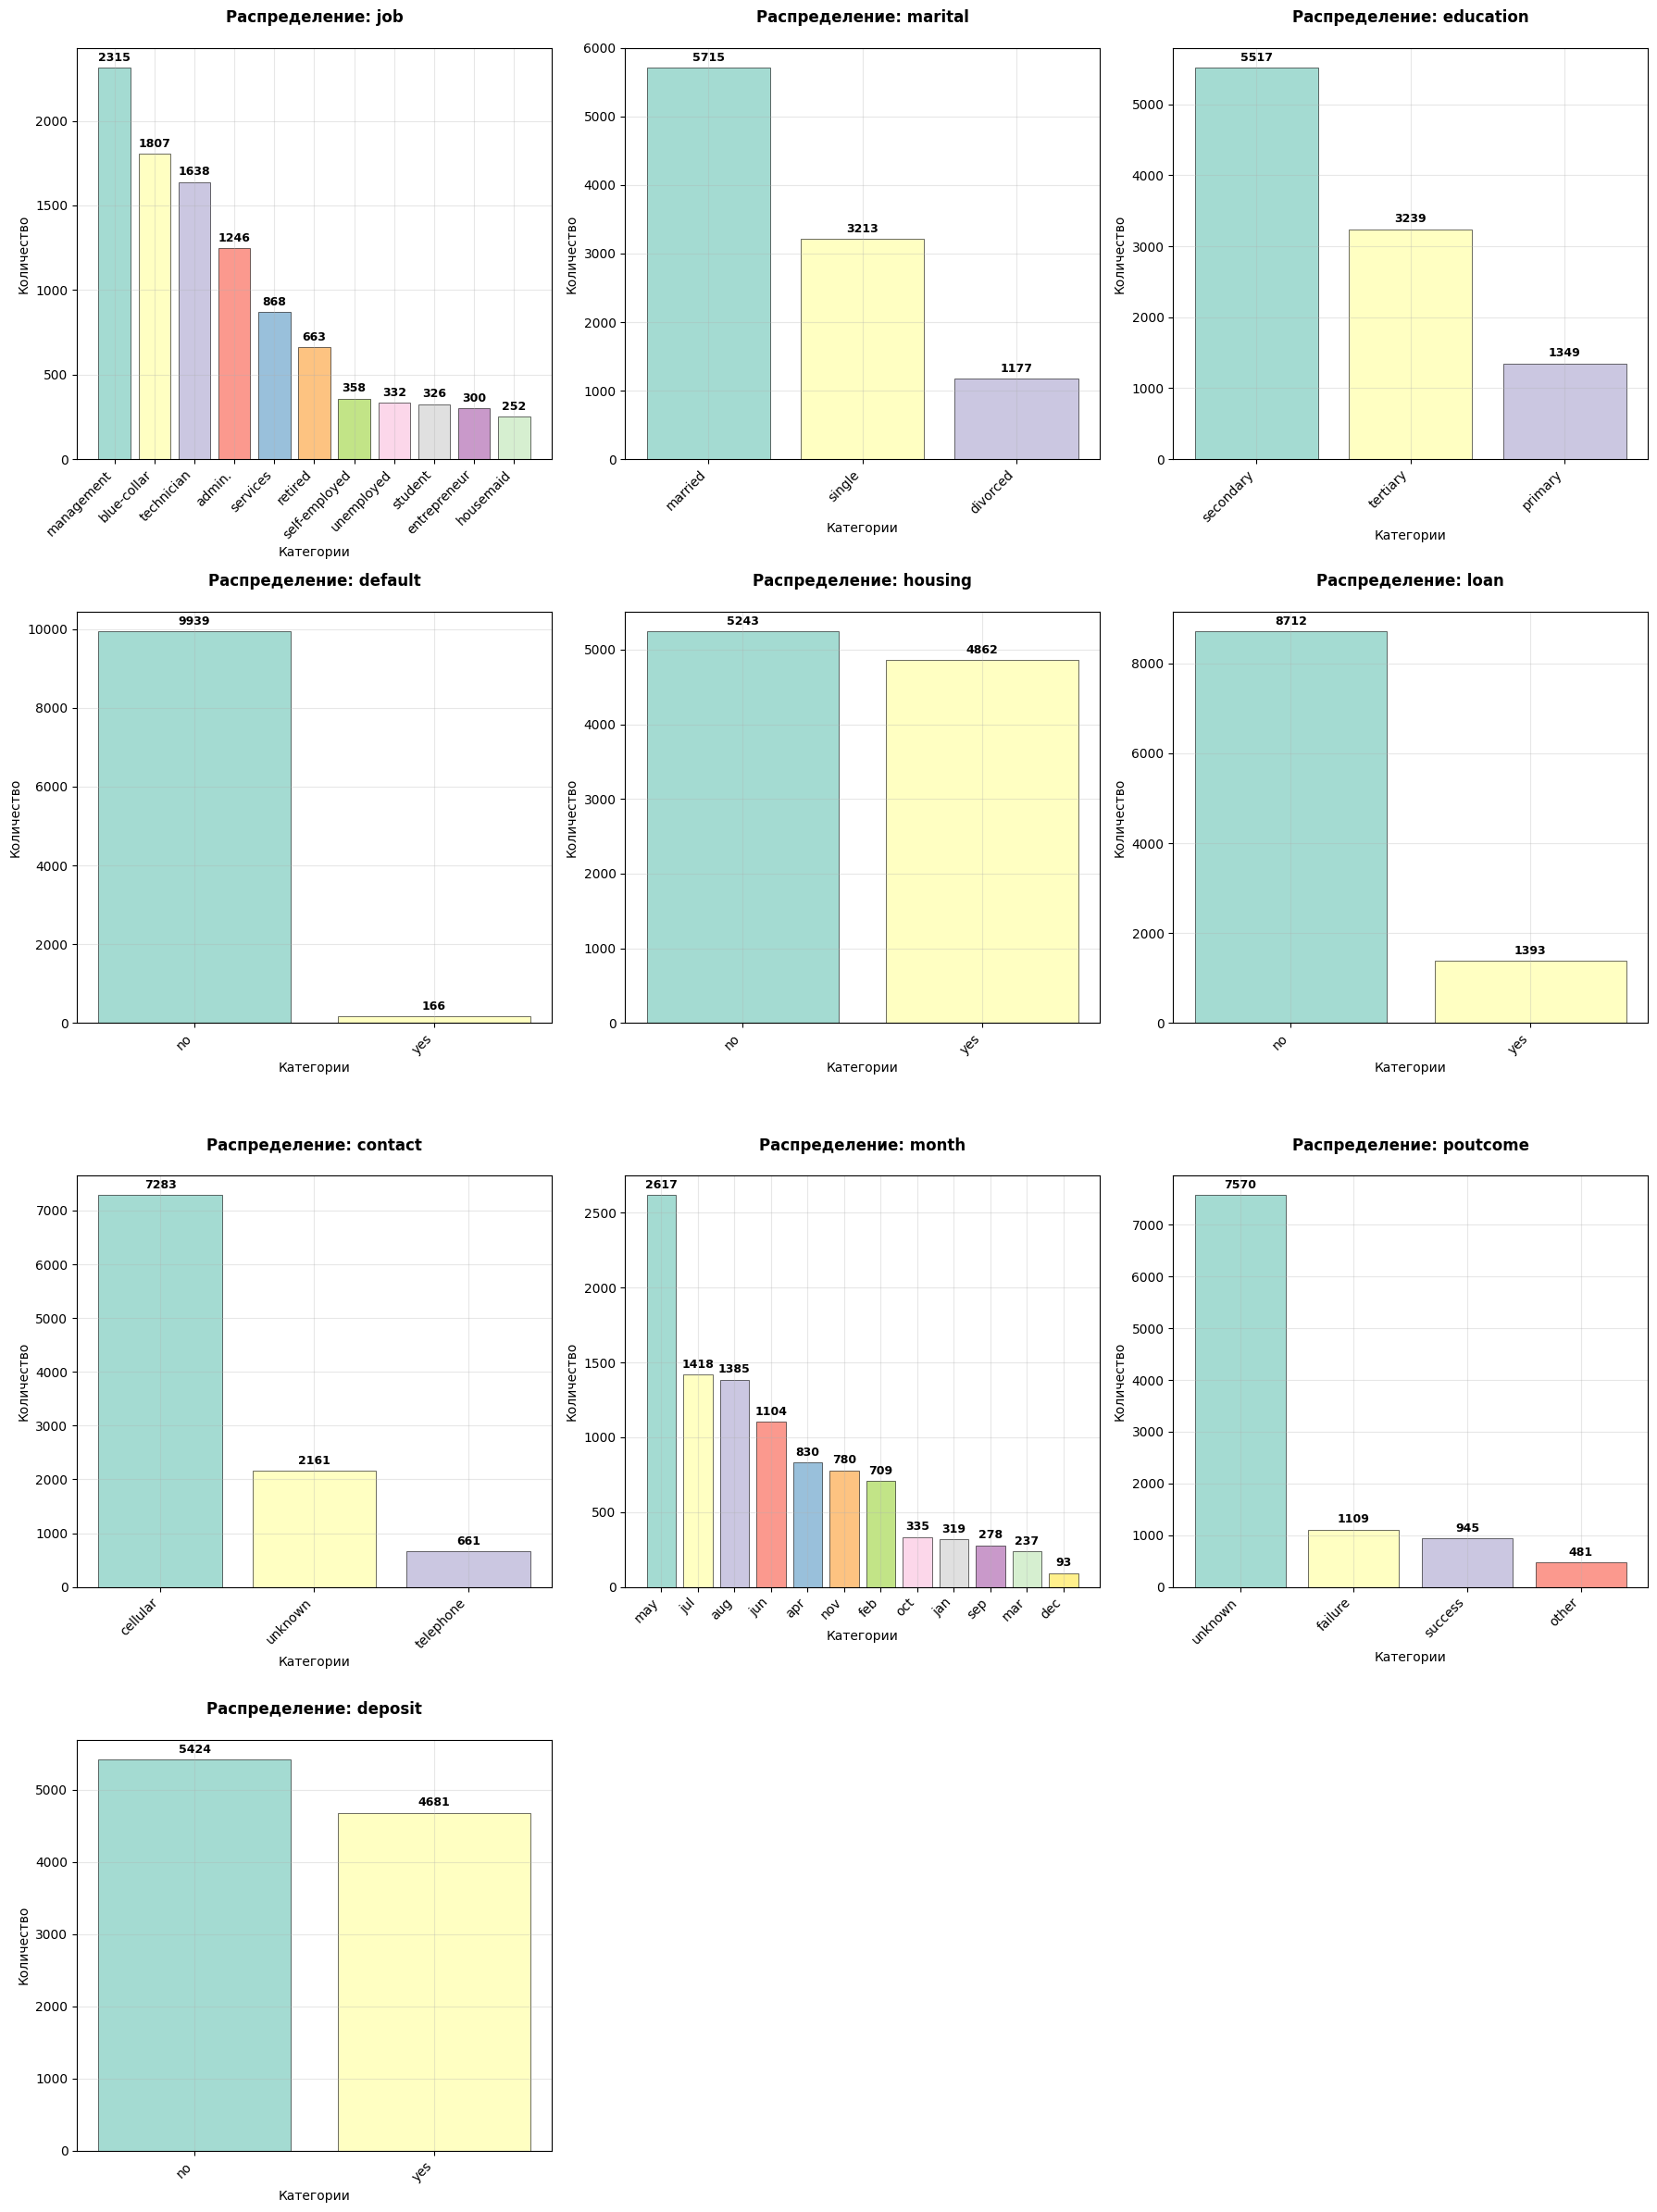

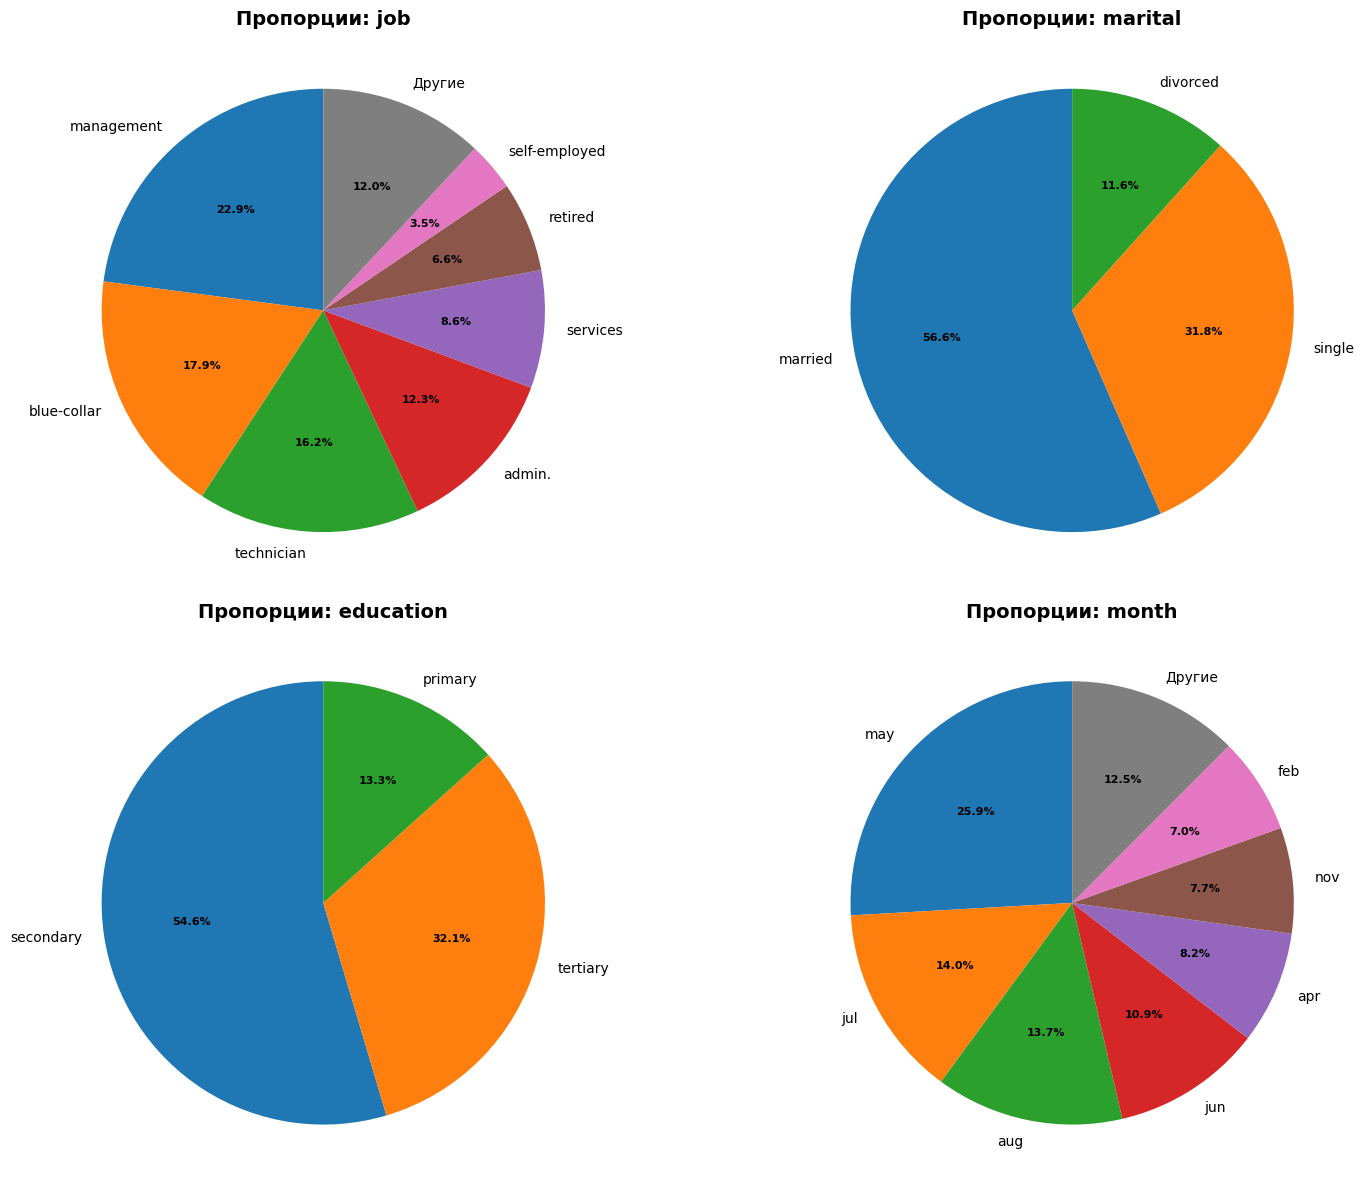



🎯 КЛЮЧЕВЫЕ ВЫВОДЫ ПО КАТЕГОРИАЛЬНЫМ ПЕРЕМЕННЫМ:
✅ ПРОФЕССИИ: Представлено 11 сфер занятости, лидирует 'management'
✅ КАМПАНИИ: Маркетинговые кампании проводились круглогодично (12 месяцев)
✅ СЕМЕЙНОЕ ПОЛОЖЕНИЕ: Чаще всего встречается 'married' (56.6%)
✅ ОБРАЗОВАНИЕ: Преобладает 'secondary' (54.6%)


In [12]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
#ваш код
#постройте визуализации, иллюстрирующие результаты

# Определяем категориальные переменные
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
print(f"Категориальные переменные: {categorical_columns}")
print()

# Подробный анализ каждой категориальной переменной
print("ПОДРОБНЫЙ АНАЛИЗ КАТЕГОРИАЛЬНЫХ ПЕРЕМЕННЫХ:")
print("=" * 80)

for col in categorical_columns:
    print(f"\n📊 ПЕРЕМЕННАЯ: {col.upper()}")
    print("-" * 60)
    
    # Основная статистика
    unique_count = df[col].nunique()
    total_count = len(df[col])
    mode_value = df[col].mode().iloc[0] if len(df[col].mode()) > 0 else "Нет моды"
    
    print(f"📈 Основная статистика:")
    print(f"   • Общее количество записей: {total_count}")
    print(f"   • Количество уникальных значений: {unique_count}")
    print(f"   • Наиболее частое значение (мода): {mode_value}")
    
    # Частотное распределение
    value_counts = df[col].value_counts()
    value_percentages = df[col].value_counts(normalize=True) * 100
    
    print(f"\n📊 Частотное распределение:")
    print(f"{'Значение':<20} {'Количество':<12} {'Процент':<10}")
    print("-" * 45)
    for value, count in value_counts.items():
        percentage = value_percentages[value]
        print(f"{str(value):<20} {count:<12} {percentage:.2f}%")
    
    # Специфичная интерпретация для каждой переменной
    print(f"\n💡 Интерпретация переменной '{col}':")
    
    if col == 'job':
        print(f"   • В банке представлены клиенты из {unique_count} различных сфер занятости")
        print(f"   • Наиболее распространенная профессия: {mode_value}")
        print(f"   • Профессиональное разнообразие клиентской базы довольно широкое")
        
        # Топ-5 профессий
        top_jobs = value_counts.head()
        print(f"   • ТОП-5 профессий:")
        for i, (job, count) in enumerate(top_jobs.items(), 1):
            print(f"     {i}. {job}: {count} чел. ({value_percentages[job]:.1f}%)")
    
    elif col == 'marital':
        print(f"   • Представлены {unique_count} категории семейного положения")
        print(f"   • Наиболее частое семейное положение: {mode_value}")
        if value_counts.iloc[0] / total_count > 0.5:
            print(f"   • Явное преобладание одной категории ({value_percentages.iloc[0]:.1f}%)")
        else:
            print(f"   • Относительно равномерное распределение по категориям")
    
    elif col == 'education':
        print(f"   • В базе представлены {unique_count} уровня образования")
        print(f"   • Наиболее распространенный уровень образования: {mode_value}")
        print(f"   • Образовательная структура клиентов:")
        for edu, percentage in value_percentages.items():
            if percentage > 10:
                print(f"     - {edu}: {percentage:.1f}% (значительная доля)")
            else:
                print(f"     - {edu}: {percentage:.1f}%")
    
    elif col == 'default':
        print(f"   • Переменная показывает наличие кредитных дефолтов")
        print(f"   • Наиболее частое значение: {mode_value}")
        if 'yes' in value_counts.index:
            default_rate = value_percentages['yes']
            print(f"   • Доля клиентов с дефолтами: {default_rate:.2f}%")
        else:
            print(f"   • Доля клиентов с дефолтами: 0%")
    
    elif col == 'housing':
        print(f"   • Переменная отражает наличие жилищного кредита")
        if 'yes' in value_counts.index:
            housing_rate = value_percentages['yes']
            print(f"   • Доля клиентов с жилищным кредитом: {housing_rate:.2f}%")
    
    elif col == 'loan':
        print(f"   • Переменная показывает наличие персонального кредита")
        if 'yes' in value_counts.index:
            loan_rate = value_percentages['yes']
            print(f"   • Доля клиентов с персональным кредитом: {loan_rate:.2f}%")
    
    elif col == 'contact':
        print(f"   • Способы связи с клиентами: {unique_count} типа")
        print(f"   • Основной способ связи: {mode_value}")
    
    elif col == 'month':
        print(f"   • Маркетинговые кампании проводились в {unique_count} месяцах")
        if unique_count == 12:
            print(f"   • Кампании проходили круглогодично")
        else:
            print(f"   • Кампании проходили не во все месяцы года")
            months_with_campaigns = list(value_counts.index)
            print(f"   • Месяцы с кампаниями: {', '.join(months_with_campaigns)}")
            
        # Наиболее/наименее активные месяцы
        most_active = value_counts.index[0]
        least_active = value_counts.index[-1]
        print(f"   • Наиболее активный месяц: {most_active} ({value_counts[most_active]} кампаний)")
        print(f"   • Наименее активный месяц: {least_active} ({value_counts[least_active]} кампаний)")
    
    elif col == 'poutcome':
        print(f"   • Результаты предыдущих маркетинговых кампаний: {unique_count} типа")
        print(f"   • Наиболее частый результат: {mode_value}")
        if 'success' in value_counts.index:
            success_rate = value_percentages['success']
            print(f"   • Доля успешных предыдущих кампаний: {success_rate:.2f}%")
    
    elif col == 'deposit':
        print(f"   • Целевая переменная - открытие депозита")
        if 'yes' in value_counts.index:
            deposit_rate = value_percentages['yes']
            print(f"   • Конверсия (доля открывших депозит): {deposit_rate:.2f}%")
            print(f"   • Эффективность маркетинговой кампании: {'высокая' if deposit_rate > 50 else 'средняя' if deposit_rate > 20 else 'низкая'}")
    
    print("-" * 60)

# Создание визуализаций для всех категориальных переменных
print(f"\n\n📊 ВИЗУАЛИЗАЦИИ КАТЕГОРИАЛЬНЫХ ПЕРЕМЕННЫХ")
print("=" * 60)

# Определяем количество строк и столбцов для subplot
n_vars = len(categorical_columns)
n_cols = 3
n_rows = (n_vars + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6*n_rows))
axes = axes.flatten() if n_vars > 1 else [axes]

# Цветовая палитра
colors = plt.cm.Set3(np.linspace(0, 1, 12))

for i, col in enumerate(categorical_columns):
    if i < len(axes):
        value_counts = df[col].value_counts()
        
        # Выбираем цвета для каждой переменной
        col_colors = colors[:len(value_counts)]
        
        # Создаем столбчатую диаграмму
        bars = axes[i].bar(range(len(value_counts)), value_counts.values, 
                          color=col_colors, alpha=0.8, edgecolor='black', linewidth=0.5)
        
        axes[i].set_title(f'Распределение: {col}', fontsize=12, fontweight='bold', pad=20)
        axes[i].set_xlabel('Категории')
        axes[i].set_ylabel('Количество')
        
        # Настройка меток на оси X
        axes[i].set_xticks(range(len(value_counts)))
        axes[i].set_xticklabels(value_counts.index, rotation=45, ha='right')
        
        # Добавляем значения на столбцы
        for bar, value in zip(bars, value_counts.values):
            height = bar.get_height()
            axes[i].text(bar.get_x() + bar.get_width()/2., height + max(value_counts)*0.01,
                        f'{value}', ha='center', va='bottom', fontweight='bold', fontsize=9)
        
        axes[i].grid(True, alpha=0.3)

# Убираем лишние subplot'ы
for i in range(len(categorical_columns), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# Круговые диаграммы для ключевых переменных
key_vars = ['job', 'marital', 'education', 'month']
key_vars = [var for var in key_vars if var in categorical_columns]

if key_vars:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    for i, col in enumerate(key_vars[:4]):
        value_counts = df[col].value_counts()
        
        # Ограничиваем количество категорий для читаемости
        if len(value_counts) > 8:
            top_values = value_counts.head(7)
            other_count = value_counts.tail(-7).sum()
            if other_count > 0:
                top_values['Другие'] = other_count
            value_counts = top_values
        
        wedges, texts, autotexts = axes[i].pie(value_counts.values, 
                                              labels=value_counts.index,
                                              autopct='%1.1f%%',
                                              startangle=90)
        
        axes[i].set_title(f'Пропорции: {col}', fontsize=14, fontweight='bold')
        
        # Улучшаем читаемость текста
        for autotext in autotexts:
            autotext.set_color('black')
            autotext.set_fontweight('bold')
            autotext.set_fontsize(8)
    
    plt.tight_layout()
    plt.show()

# Итоговые выводы
print(f"\n\n🎯 КЛЮЧЕВЫЕ ВЫВОДЫ ПО КАТЕГОРИАЛЬНЫМ ПЕРЕМЕННЫМ:")
print("=" * 80)

# Анализ профессий
if 'job' in df.columns:
    job_count = df['job'].nunique()
    top_job = df['job'].mode().iloc[0]
    print(f"✅ ПРОФЕССИИ: Представлено {job_count} сфер занятости, лидирует '{top_job}'")

# Анализ месяцев
if 'month' in df.columns:
    month_count = df['month'].nunique()
    if month_count == 12:
        print(f"✅ КАМПАНИИ: Маркетинговые кампании проводились круглогодично ({month_count} месяцев)")
    else:
        print(f"⚠️  КАМПАНИИ: Кампании проводились только в {month_count} месяцах из 12")

# Анализ семейного положения
if 'marital' in df.columns:
    top_marital = df['marital'].mode().iloc[0]
    marital_pct = (df['marital'].value_counts(normalize=True).iloc[0] * 100)
    print(f"✅ СЕМЕЙНОЕ ПОЛОЖЕНИЕ: Чаще всего встречается '{top_marital}' ({marital_pct:.1f}%)")

# Анализ образования
if 'education' in df.columns:
    top_education = df['education'].mode().iloc[0]
    edu_pct = (df['education'].value_counts(normalize=True).iloc[0] * 100)
    print(f"✅ ОБРАЗОВАНИЕ: Преобладает '{top_education}' ({edu_pct:.1f}%)")

print("=" * 80)



### Задание 6

In [22]:
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_group
0,59,admin.,married,secondary,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes,50-59
1,56,admin.,married,secondary,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes,50-59
2,41,technician,married,secondary,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes,40-49
3,55,services,married,secondary,no,2476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,yes,50-59
4,54,admin.,married,tertiary,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,yes,50-59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,no,1.0,yes,no,cellular,20,apr,257,1,-1,0,unknown,no,30-39
11158,39,services,married,secondary,no,733.0,no,no,unknown,16,jun,83,4,-1,0,unknown,no,30-39
11159,32,technician,single,secondary,no,29.0,no,no,cellular,19,aug,156,2,-1,0,unknown,no,30-39
11160,43,technician,married,secondary,no,0.0,no,yes,cellular,8,may,9,2,172,5,failure,no,40-49


<Axes: xlabel='count', ylabel='poutcome'>

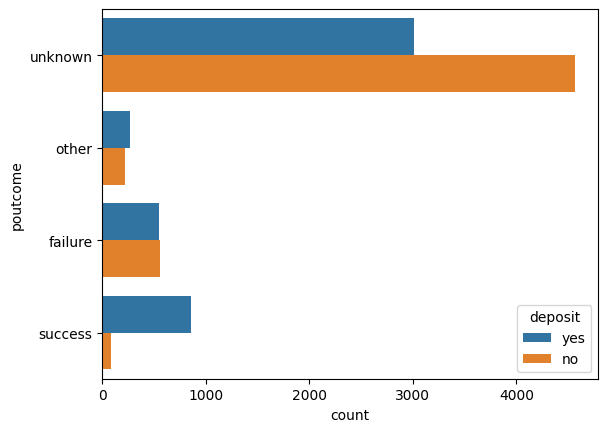

In [23]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
sns.countplot(y='poutcome', hue='deposit', data=df)

### Задание 7

<Axes: xlabel='count', ylabel='month'>

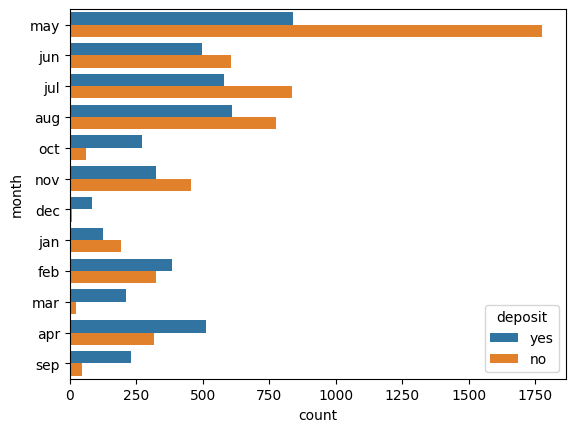

In [21]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
sns.countplot(y='month', hue='deposit', data=df)

### Задание 8

<Axes: xlabel='age_group', ylabel='count'>

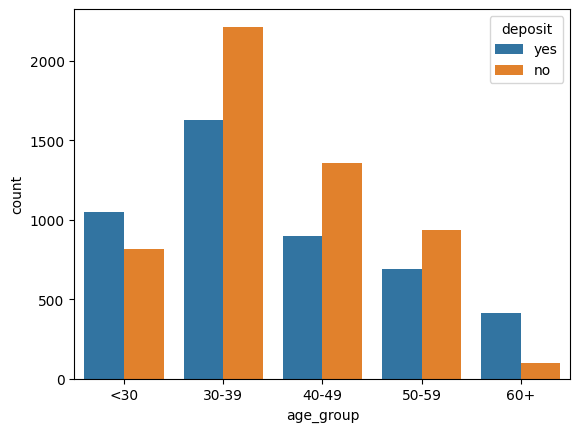

In [15]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
df['age_group'] = pd.cut(df.age, [0,30,40,50,60,9999], labels = ['<30','30-39','40-49','50-59','60+'])
sns.countplot(x='age_group', hue='deposit', data=df)

### Задания 9 и 10

<Axes: xlabel='count', ylabel='marital'>

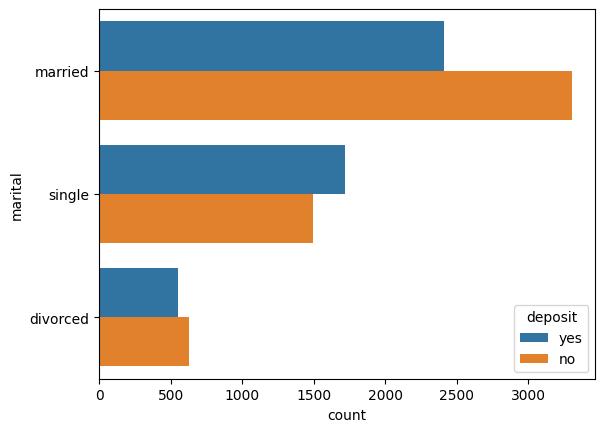

In [ ]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
sns.countplot(y='marital', hue='deposit', data=df)

<Axes: xlabel='count', ylabel='education'>

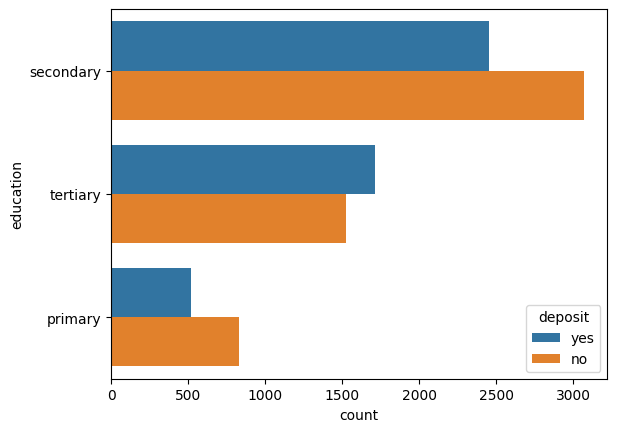

In [19]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
sns.countplot(y='education', hue='deposit', data=df)

<Axes: xlabel='count', ylabel='job'>

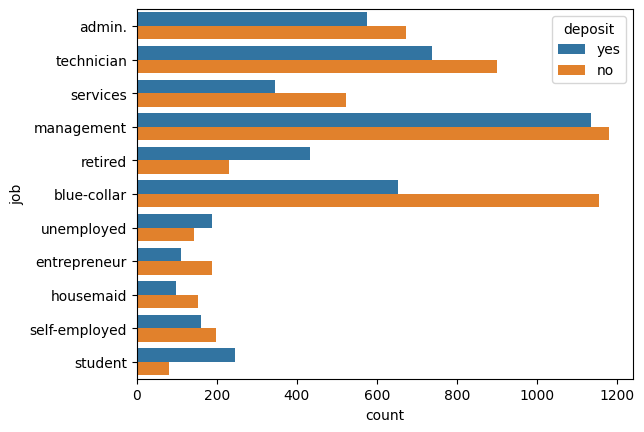

In [20]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
sns.countplot(y='job', hue='deposit', data=df)

### Задание 11

АНАЛИЗ ПЕРЕСЕЧЕНИЙ ОБРАЗОВАНИЯ И СЕМЕЙНОГО СТАТУСА
(среди клиентов, открывших депозит)
📊 Общая информация:
   • Всего клиентов в данных: 10105
   • Клиентов, открывших депозит: 4681
   • Доля открывших депозит: 46.32%

📈 СВОДНАЯ ТАБЛИЦА: ОБРАЗОВАНИЕ × СЕМЕЙНЫЙ СТАТУС
(количество клиентов, открывших депозит)
-----------------------------------------------------------------
marital    divorced  married  single   All
education                                 
primary          96      339      82   517
secondary       283     1289     879  2451
tertiary        174      784     755  1713
All             553     2412    1716  4681

📊 ПРОЦЕНТНОЕ РАСПРЕДЕЛЕНИЕ
(% от общего числа открывших депозит)
---------------------------------------------
marital    divorced  married  single
education                           
primary        2.05     7.24    1.75
secondary      6.05    27.54   18.78
tertiary       3.72    16.75   16.13

🎯 САМОЕ МНОГОЧИСЛЕННОЕ ПЕРЕСЕЧЕНИЕ:
---------------------------------

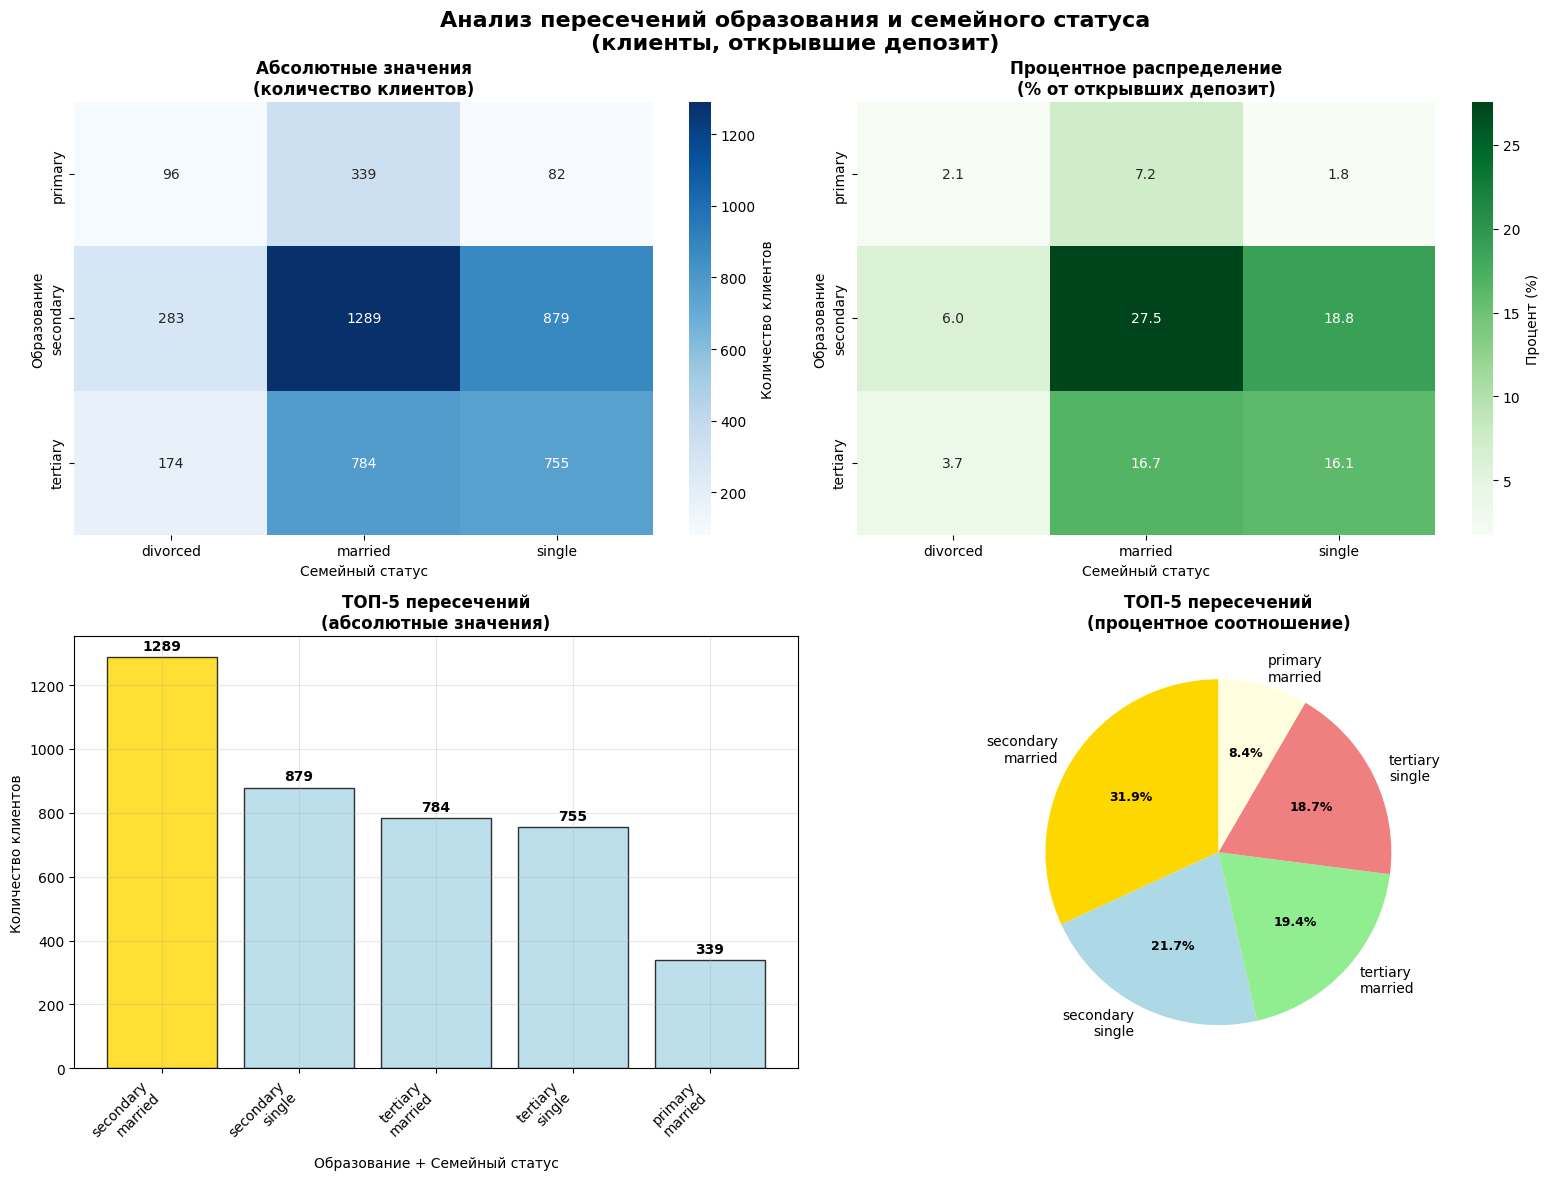

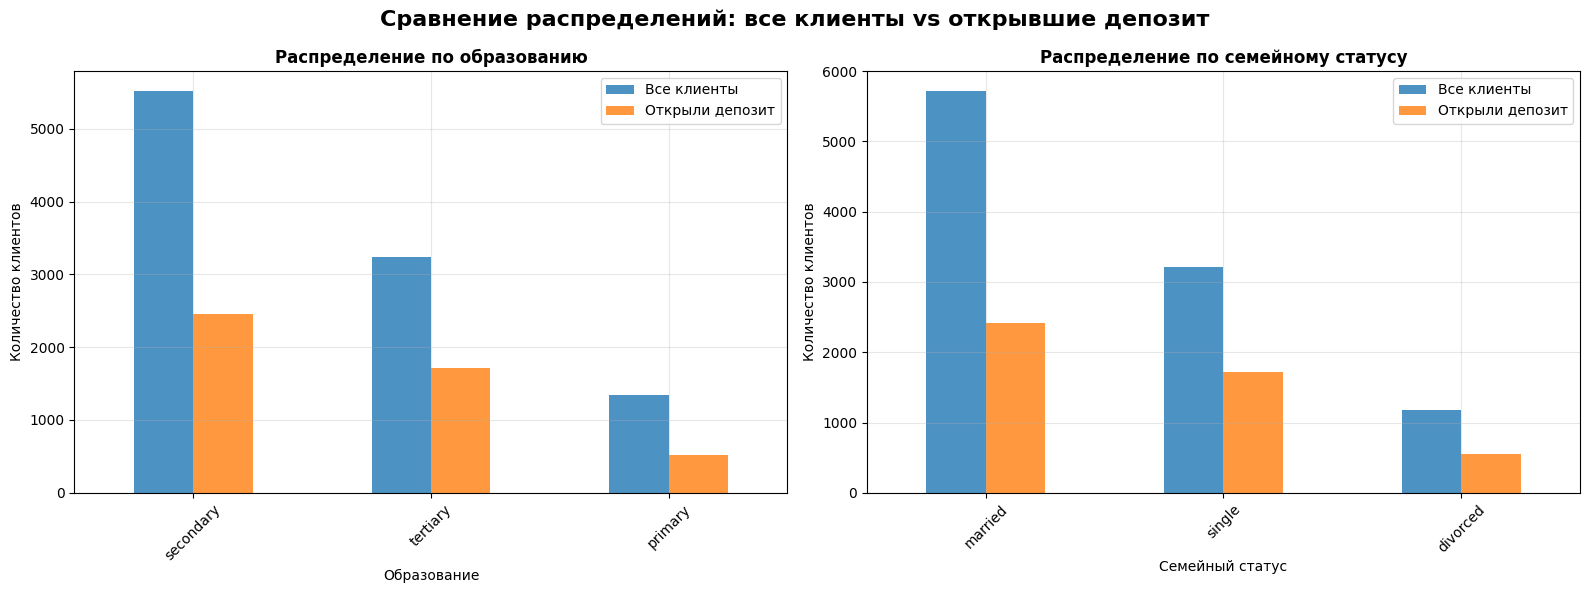

📊 СТАТИСТИЧЕСКИЙ АНАЛИЗ:
----------------------------------------
Хи-квадрат статистика: 142.5737
P-значение: 0.000000
Степени свободы: 4
✅ Связь между образованием и семейным статусом среди открывших депозит статистически значима

💡 БИЗНЕС-ВЫВОДЫ И РЕКОМЕНДАЦИИ:
---------------------------------------------
🎯 Целевая группа №1: secondary образование + married
   • Размер сегмента: 1289 клиентов (27.5% от успешных)
   • Рекомендация: Приоритетный фокус маркетинговых кампаний

📈 Дополнительные приоритетные сегменты:
   2. secondary + single: 879 чел. (18.8%)
   3. tertiary + married: 784 чел. (16.7%)

📊 Концентрация ТОП-3 сегментов: 63.1% успешных клиентов
   ✅ Высокая концентрация - можно эффективно таргетировать

🎯 ФИНАЛЬНЫЙ ОТВЕТ:
Самое многочисленное пересечение категорий:
• ОБРАЗОВАНИЕ: secondary
• СЕМЕЙНЫЙ СТАТУС: married
• КОЛИЧЕСТВО КЛИЕНТОВ: 1289



In [39]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)

# Проверяем наличие необходимых переменных
if all(col in df.columns for col in ['education', 'marital', 'deposit']):
    
    print("АНАЛИЗ ПЕРЕСЕЧЕНИЙ ОБРАЗОВАНИЯ И СЕМЕЙНОГО СТАТУСА")
    print("(среди клиентов, открывших депозит)")
    print("=" * 65)
    
    # Фильтруем данные - только те, кто открыл депозит
    deposit_clients = df[df['deposit'] == 'yes'].copy()
    
    print(f"📊 Общая информация:")
    print(f"   • Всего клиентов в данных: {len(df)}")
    print(f"   • Клиентов, открывших депозит: {len(deposit_clients)}")
    print(f"   • Доля открывших депозит: {len(deposit_clients)/len(df)*100:.2f}%")
    print()
    
    # Создаем сводную таблицу (кросс-табуляцию)
    pivot_table = pd.crosstab(deposit_clients['education'], 
                             deposit_clients['marital'], 
                             margins=True)
    
    print("📈 СВОДНАЯ ТАБЛИЦА: ОБРАЗОВАНИЕ × СЕМЕЙНЫЙ СТАТУС")
    print("(количество клиентов, открывших депозит)")
    print("-" * 65)
    print(pivot_table)
    print()
    
    # Процентное распределение
    pivot_table_pct = pd.crosstab(deposit_clients['education'], 
                                 deposit_clients['marital'], 
                                 normalize='all') * 100
    
    print("📊 ПРОЦЕНТНОЕ РАСПРЕДЕЛЕНИЕ")
    print("(% от общего числа открывших депозит)")
    print("-" * 45)
    print(pivot_table_pct.round(2))
    print()
    
    # Находим самое многочисленное пересечение
    # Исключаем строку и столбец с итогами
    pivot_no_margins = pd.crosstab(deposit_clients['education'], deposit_clients['marital'])
    
    # Находим максимальное значение и его позицию
    max_value = pivot_no_margins.max().max()
    max_position = pivot_no_margins.stack().idxmax()
    max_education, max_marital = max_position
    
    print("🎯 САМОЕ МНОГОЧИСЛЕННОЕ ПЕРЕСЕЧЕНИЕ:")
    print("-" * 45)
    print(f"✅ Образование: {max_education}")
    print(f"✅ Семейный статус: {max_marital}")
    print(f"✅ Количество клиентов: {max_value}")
    print(f"✅ Доля от открывших депозит: {max_value/len(deposit_clients)*100:.2f}%")
    print(f"✅ Доля от всех клиентов: {max_value/len(df)*100:.2f}%")
    print()
    
    # ТОП-5 пересечений
    print("🏆 ТОП-5 САМЫХ МНОГОЧИСЛЕННЫХ ПЕРЕСЕЧЕНИЙ:")
    print("-" * 50)
    
    # Преобразуем в Series для сортировки
    combinations = pivot_no_margins.stack().sort_values(ascending=False)
    
    for i, ((education, marital), count) in enumerate(combinations.head().items(), 1):
        percentage = count / len(deposit_clients) * 100
        print(f"{i}. {education} + {marital}: {count} чел. ({percentage:.2f}%)")
    
    print()
    
    # Детальный анализ самого многочисленного пересечения
    print("🔍 ДЕТАЛЬНЫЙ АНАЛИЗ САМОГО МНОГОЧИСЛЕННОГО ПЕРЕСЕЧЕНИЯ:")
    print("-" * 60)
    
    # Фильтруем данные для самого многочисленного пересечения
    target_group = df[(df['education'] == max_education) & (df['marital'] == max_marital)]
    target_group_deposits = target_group[target_group['deposit'] == 'yes']
    
    print(f"📋 Группа: {max_education} образование + {max_marital}")
    print(f"   • Всего клиентов в этой группе: {len(target_group)}")
    print(f"   • Открыли депозит: {len(target_group_deposits)}")
    print(f"   • Не открыли депозит: {len(target_group) - len(target_group_deposits)}")
    print(f"   • Коэффициент открытия депозитов в группе: {len(target_group_deposits)/len(target_group)*100:.2f}%")
    print()
    
    # Дополнительная статистика по целевой группе
    if len(target_group) > 0:
        print("📊 Дополнительная статистика целевой группы:")
        
        # Средний возраст
        if 'age' in target_group.columns:
            avg_age = target_group['age'].mean()
            print(f"   • Средний возраст: {avg_age:.1f} лет")
        
        # Наиболее частые профессии
        if 'job' in target_group.columns:
            top_jobs = target_group['job'].value_counts().head(3)
            print(f"   • ТОП-3 профессии:")
            for job, count in top_jobs.items():
                percentage = count / len(target_group) * 100
                print(f"     - {job}: {count} чел. ({percentage:.1f}%)")
        
        print()
    
    # Создаем визуализации
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Анализ пересечений образования и семейного статуса\n(клиенты, открывшие депозит)', 
                 fontsize=16, fontweight='bold')
    
    # 1. Тепловая карта сводной таблицы (абсолютные значения)
    sns.heatmap(pivot_no_margins, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0],
                cbar_kws={'label': 'Количество клиентов'})
    axes[0, 0].set_title('Абсолютные значения\n(количество клиентов)', fontweight='bold', fontsize=12)
    axes[0, 0].set_xlabel('Семейный статус')
    axes[0, 0].set_ylabel('Образование')
    
    # 2. Тепловая карта процентного распределения
    sns.heatmap(pivot_table_pct, annot=True, fmt='.1f', cmap='Greens', ax=axes[0, 1],
                cbar_kws={'label': 'Процент (%)'})
    axes[0, 1].set_title('Процентное распределение\n(% от открывших депозит)', fontweight='bold', fontsize=12)
    axes[0, 1].set_xlabel('Семейный статус')
    axes[0, 1].set_ylabel('Образование')
    
    # 3. Столбчатая диаграмма ТОП-5 пересечений
    top_5_combinations = combinations.head()
    labels = [f"{edu}\n{mar}" for (edu, mar) in top_5_combinations.index]
    values = top_5_combinations.values
    
    colors = ['gold' if i == 0 else 'lightblue' for i in range(len(values))]
    bars = axes[1, 0].bar(range(len(values)), values, color=colors, alpha=0.8, edgecolor='black')
    
    axes[1, 0].set_title('ТОП-5 пересечений\n(абсолютные значения)', fontweight='bold', fontsize=12)
    axes[1, 0].set_xlabel('Образование + Семейный статус')
    axes[1, 0].set_ylabel('Количество клиентов')
    axes[1, 0].set_xticks(range(len(values)))
    axes[1, 0].set_xticklabels(labels, rotation=45, ha='right')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Добавляем значения на столбцы
    for bar, value in zip(bars, values):
        height = bar.get_height()
        axes[1, 0].text(bar.get_x() + bar.get_width()/2., height + max(values)*0.01,
                       f'{value}', ha='center', va='bottom', fontweight='bold')
    
    # 4. Круговая диаграмма ТОП-5 пересечений
    colors_pie = ['gold', 'lightblue', 'lightgreen', 'lightcoral', 'lightyellow']
    
    wedges, texts, autotexts = axes[1, 1].pie(values, 
                                             labels=[f"{edu}\n{mar}" for (edu, mar) in top_5_combinations.index],
                                             autopct='%1.1f%%',
                                             colors=colors_pie[:len(values)],
                                             startangle=90)
    
    axes[1, 1].set_title('ТОП-5 пересечений\n(процентное соотношение)', fontweight='bold', fontsize=12)
    
    for autotext in autotexts:
        autotext.set_color('black')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(9)
    
    plt.tight_layout()
    plt.show()
    
    # Дополнительная визуализация - сравнение с общим распределением
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle('Сравнение распределений: все клиенты vs открывшие депозит', 
                 fontsize=16, fontweight='bold')
    
    # Распределение по образованию
    education_all = df['education'].value_counts()
    education_deposit = deposit_clients['education'].value_counts()
    
    comparison_education = pd.DataFrame({
        'Все клиенты': education_all,
        'Открыли депозит': education_deposit
    }).fillna(0)
    
    comparison_education.plot(kind='bar', ax=axes[0], alpha=0.8)
    axes[0].set_title('Распределение по образованию', fontweight='bold', fontsize=12)
    axes[0].set_xlabel('Образование')
    axes[0].set_ylabel('Количество клиентов')
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Распределение по семейному статусу
    marital_all = df['marital'].value_counts()
    marital_deposit = deposit_clients['marital'].value_counts()
    
    comparison_marital = pd.DataFrame({
        'Все клиенты': marital_all,
        'Открыли депозит': marital_deposit
    }).fillna(0)
    
    comparison_marital.plot(kind='bar', ax=axes[1], alpha=0.8)
    axes[1].set_title('Распределение по семейному статусу', fontweight='bold', fontsize=12)
    axes[1].set_xlabel('Семейный статус')
    axes[1].set_ylabel('Количество клиентов')
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Статистический анализ
    from scipy.stats import chi2_contingency
    
    chi2, p_value, dof, expected = chi2_contingency(pivot_no_margins)
    
    print("📊 СТАТИСТИЧЕСКИЙ АНАЛИЗ:")
    print("-" * 40)
    print(f"Хи-квадрат статистика: {chi2:.4f}")
    print(f"P-значение: {p_value:.6f}")
    print(f"Степени свободы: {dof}")
    
    if p_value < 0.05:
        print("✅ Связь между образованием и семейным статусом среди открывших депозит статистически значима")
    else:
        print("❌ Связь между образованием и семейным статусом среди открывших депозит статистически НЕ значима")
    
    print()
    
    # Бизнес-выводы
    print("💡 БИЗНЕС-ВЫВОДЫ И РЕКОМЕНДАЦИИ:")
    print("-" * 45)
    print(f"🎯 Целевая группа №1: {max_education} образование + {max_marital}")
    print(f"   • Размер сегмента: {max_value} клиентов ({max_value/len(deposit_clients)*100:.1f}% от успешных)")
    print(f"   • Рекомендация: Приоритетный фокус маркетинговых кампаний")
    
    # ТОП-3 для дополнительного фокуса
    print(f"\n📈 Дополнительные приоритетные сегменты:")
    for i, ((education, marital), count) in enumerate(combinations.head(3).items(), 1):
        if i == 1:  # Пропускаем первый, так как он уже описан выше
            continue
        percentage = count / len(deposit_clients) * 100
        print(f"   {i}. {education} + {marital}: {count} чел. ({percentage:.1f}%)")
    
    # Анализ концентрации
    top_3_total = combinations.head(3).sum()
    concentration = top_3_total / len(deposit_clients) * 100
    print(f"\n📊 Концентрация ТОП-3 сегментов: {concentration:.1f}% успешных клиентов")
    
    if concentration > 50:
        print("   ✅ Высокая концентрация - можно эффективно таргетировать")
    else:
        print("   ⚠️  Низкая концентрация - нужна более широкая стратегия")
    
    print()
    
    # ФИНАЛЬНЫЙ ОТВЕТ
    print("🎯 ФИНАЛЬНЫЙ ОТВЕТ:")
    print("=" * 40)
    print(f"Самое многочисленное пересечение категорий:")
    print(f"• ОБРАЗОВАНИЕ: {max_education}")
    print(f"• СЕМЕЙНЫЙ СТАТУС: {max_marital}")
    print(f"• КОЛИЧЕСТВО КЛИЕНТОВ: {max_value}")
    print("=" * 40)

else:
    print("❌ Не найдены необходимые переменные: 'education', 'marital', 'deposit'")

print("\n" + "=" * 65)

## Часть 3: преобразование данных

### Задание 1

ОБРАБОТКА КАТЕГОРИАЛЬНОГО ПОРЯДКОВОГО ПРИЗНАКА 'EDUCATION'
📊 Исходное распределение уровней образования:
   secondary: 5517 (54.60%)
   tertiary: 3239 (32.05%)
   primary: 1349 (13.35%)

📋 Уникальные значения до обработки:
   ['secondary', 'tertiary', 'primary']
   Количество уникальных значений: 3

✅ LabelEncoder применен к признаку 'education'

🔄 РЕЗУЛЬТАТЫ КОДИРОВАНИЯ:
----------------------------------------
Соответствие: исходное значение → закодированное значение
   'primary' → 0
   'secondary' → 1
   'tertiary' → 2

📈 Распределение закодированных значений:
   0 ('primary'): 1349 (13.35%)
   1 ('secondary'): 5517 (54.60%)
   2 ('tertiary'): 3239 (32.05%)

🔍 ПРОВЕРКА КОРРЕКТНОСТИ:
-----------------------------------
Количество уникальных значений до кодирования: 3
Количество уникальных значений после кодирования: 3
✅ Количество уникальных значений сохранилось
Пропуски в исходном столбце: 0
Пропуски в закодированном столбце: 0
✅ Пропуски отсутствуют в обоих столбцах

📋 ПРИМЕР ПРЕОБ

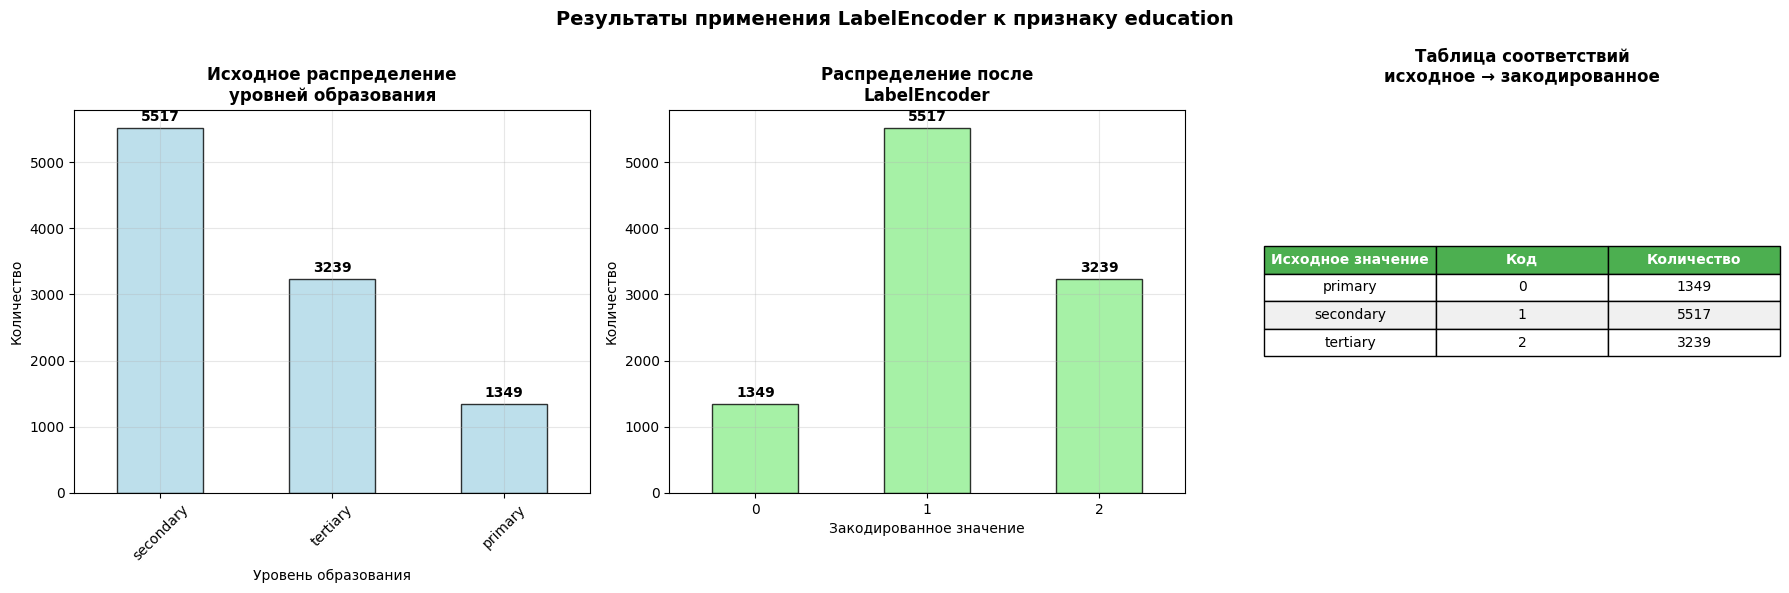

💡 ИНТЕРПРЕТАЦИЯ РЕЗУЛЬТАТОВ:
----------------------------------------
✅ LabelEncoder успешно применен к признаку 'education'
✅ Каждому уникальному уровню образования присвоен числовой код
✅ Кодирование выполнено в алфавитном порядке (по умолчанию)
✅ Все исходные значения сохранены в закодированном виде
✅ Новый признак 'education_encoded' готов для использования в ML-моделях

ℹ️  ПРИМЕЧАНИЕ:
   LabelEncoder присваивает коды в алфавитном порядке значений.
   Это НЕ означает, что присвоенные числа отражают порядок важности.
   Для порядковых признаков может потребоваться ручное переназначение.



In [40]:
# преобразуйте уровни образования

# Проверяем исходные данные
print("ОБРАБОТКА КАТЕГОРИАЛЬНОГО ПОРЯДКОВОГО ПРИЗНАКА 'EDUCATION'")
print("=" * 65)

if 'education' in df.columns:
    print("📊 Исходное распределение уровней образования:")
    education_counts = df['education'].value_counts()
    for education, count in education_counts.items():
        percentage = (count / len(df)) * 100
        print(f"   {education}: {count} ({percentage:.2f}%)")
    print()
    
    print("📋 Уникальные значения до обработки:")
    unique_education = df['education'].unique()
    print(f"   {list(unique_education)}")
    print(f"   Количество уникальных значений: {len(unique_education)}")
    print()
    
    # Применяем LabelEncoder
    from sklearn.preprocessing import LabelEncoder
    
    # Создаем экземпляр LabelEncoder
    label_encoder = LabelEncoder()
    
    # Применяем LabelEncoder к столбцу education
    df['education_encoded'] = label_encoder.fit_transform(df['education'])
    
    print("✅ LabelEncoder применен к признаку 'education'")
    print()
    
    # Показываем результаты кодирования
    print("🔄 РЕЗУЛЬТАТЫ КОДИРОВАНИЯ:")
    print("-" * 40)
    
    # Создаем таблицу соответствий
    mapping_dict = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
    print("Соответствие: исходное значение → закодированное значение")
    for original, encoded in sorted(mapping_dict.items(), key=lambda x: x[1]):
        print(f"   '{original}' → {encoded}")
    print()
    
    # Проверяем результат
    print("📈 Распределение закодированных значений:")
    encoded_counts = df['education_encoded'].value_counts().sort_index()
    for encoded_value, count in encoded_counts.items():
        original_value = label_encoder.inverse_transform([encoded_value])[0]
        percentage = (count / len(df)) * 100
        print(f"   {encoded_value} ('{original_value}'): {count} ({percentage:.2f}%)")
    print()
    
    # Проверяем корректность преобразования
    print("🔍 ПРОВЕРКА КОРРЕКТНОСТИ:")
    print("-" * 35)
    
    # Сравниваем количества до и после
    original_unique_count = len(df['education'].unique())
    encoded_unique_count = len(df['education_encoded'].unique())
    
    print(f"Количество уникальных значений до кодирования: {original_unique_count}")
    print(f"Количество уникальных значений после кодирования: {encoded_unique_count}")
    
    if original_unique_count == encoded_unique_count:
        print("✅ Количество уникальных значений сохранилось")
    else:
        print("❌ Количество уникальных значений изменилось!")
    
    # Проверяем отсутствие пропусков
    missing_original = df['education'].isnull().sum()
    missing_encoded = df['education_encoded'].isnull().sum()
    
    print(f"Пропуски в исходном столбце: {missing_original}")
    print(f"Пропуски в закодированном столбце: {missing_encoded}")
    
    if missing_original == missing_encoded == 0:
        print("✅ Пропуски отсутствуют в обоих столбцах")
    elif missing_original == missing_encoded:
        print("✅ Количество пропусков сохранилось")
    else:
        print("❌ Количество пропусков изменилось!")
    
    print()
    
    # Показываем первые несколько строк для наглядности
    print("📋 ПРИМЕР ПРЕОБРАЗОВАНИЯ (первые 10 строк):")
    print("-" * 50)
    comparison_df = df[['education', 'education_encoded']].head(10)
    print(comparison_df.to_string(index=False))
    print()
    
    # Статистика по новому столбцу
    print("📊 СТАТИСТИКА ЗАКОДИРОВАННОГО ПРИЗНАКА:")
    print("-" * 45)
    print(f"Минимальное значение: {df['education_encoded'].min()}")
    print(f"Максимальное значение: {df['education_encoded'].max()}")
    print(f"Среднее значение: {df['education_encoded'].mean():.2f}")
    print(f"Медиана: {df['education_encoded'].median():.1f}")
    print(f"Стандартное отклонение: {df['education_encoded'].std():.2f}")
    print()
    
    # Информация о классах LabelEncoder
    print("🏷️ ИНФОРМАЦИЯ О LABELENCODER:")
    print("-" * 35)
    print(f"Классы (упорядочены по алфавиту): {list(label_encoder.classes_)}")
    print(f"Количество классов: {len(label_encoder.classes_)}")
    print()
    
    # Визуализация результатов
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle('Результаты применения LabelEncoder к признаку education', 
                 fontsize=14, fontweight='bold')
    
    # 1. Исходное распределение
    education_counts.plot(kind='bar', ax=axes[0], color='lightblue', alpha=0.8, edgecolor='black')
    axes[0].set_title('Исходное распределение\nуровней образования', fontweight='bold')
    axes[0].set_xlabel('Уровень образования')
    axes[0].set_ylabel('Количество')
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].grid(True, alpha=0.3)
    
    # Добавляем значения на столбцы
    for i, v in enumerate(education_counts.values):
        axes[0].text(i, v + max(education_counts.values) * 0.01, str(v), 
                    ha='center', va='bottom', fontweight='bold')
    
    # 2. Закодированное распределение
    encoded_counts.plot(kind='bar', ax=axes[1], color='lightgreen', alpha=0.8, edgecolor='black')
    axes[1].set_title('Распределение после\nLabelEncoder', fontweight='bold')
    axes[1].set_xlabel('Закодированное значение')
    axes[1].set_ylabel('Количество')
    axes[1].tick_params(axis='x', rotation=0)
    axes[1].grid(True, alpha=0.3)
    
    # Добавляем значения на столбцы
    for i, v in enumerate(encoded_counts.values):
        axes[1].text(i, v + max(encoded_counts.values) * 0.01, str(v), 
                    ha='center', va='bottom', fontweight='bold')
    
    # 3. Таблица соответствий
    axes[2].axis('off')
    
    # Создаем таблицу соответствий для отображения
    mapping_data = []
    for original, encoded in sorted(mapping_dict.items(), key=lambda x: x[1]):
        count = education_counts[original]
        mapping_data.append([original, encoded, count])
    
    table = axes[2].table(cellText=mapping_data,
                         colLabels=['Исходное значение', 'Код', 'Количество'],
                         cellLoc='center',
                         loc='center')
    
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    
    # Стилизация таблицы
    for i in range(len(mapping_data) + 1):
        for j in range(3):
            cell = table[(i, j)]
            if i == 0:  # Заголовок
                cell.set_facecolor('#4CAF50')
                cell.set_text_props(weight='bold', color='white')
            else:
                cell.set_facecolor('#f0f0f0' if i % 2 == 0 else 'white')
    
    axes[2].set_title('Таблица соответствий\nисходное → закодированное', 
                     fontweight='bold', pad=20)
    
    plt.tight_layout()
    plt.show()
    
    print("💡 ИНТЕРПРЕТАЦИЯ РЕЗУЛЬТАТОВ:")
    print("-" * 40)
    print("✅ LabelEncoder успешно применен к признаку 'education'")
    print("✅ Каждому уникальному уровню образования присвоен числовой код")
    print("✅ Кодирование выполнено в алфавитном порядке (по умолчанию)")
    print("✅ Все исходные значения сохранены в закодированном виде")
    print("✅ Новый признак 'education_encoded' готов для использования в ML-моделях")
    print()
    
    print("ℹ️  ПРИМЕЧАНИЕ:")
    print("   LabelEncoder присваивает коды в алфавитном порядке значений.")
    print("   Это НЕ означает, что присвоенные числа отражают порядок важности.")
    print("   Для порядковых признаков может потребоваться ручное переназначение.")
    
else:
    print("❌ Столбец 'education' не найден в данных")

print("\n" + "=" * 65)



### Задания 2 и 3

ОБРАБОТКА ПРИЗНАКА 'AGE_GROUP' С ПОМОЩЬЮ LABELENCODER
📊 Исходное распределение возрастных групп:
   30-40: 3961 (39.20%)
   40-50: 2382 (23.57%)
   50-60: 1654 (16.37%)
   <30: 1455 (14.40%)
   60+: 653 (6.46%)

📋 Уникальные значения до обработки:
   ['50-60', '40-50', '60+', '30-40', '<30']
   Количество уникальных значений: 5

✅ LabelEncoder применен к признаку 'age_group'

🔄 РЕЗУЛЬТАТЫ КОДИРОВАНИЯ:
----------------------------------------
Соответствие: исходное значение → закодированное значение
   '30-40' → 0
   '40-50' → 1
   '50-60' → 2
   '60+' → 3
   '<30' → 4

📈 Распределение закодированных значений:
   0 ('30-40'): 3961 (39.20%)
   1 ('40-50'): 2382 (23.57%)
   2 ('50-60'): 1654 (16.37%)
   3 ('60+'): 653 (6.46%)
   4 ('<30'): 1455 (14.40%)

📋 ПРИМЕР ПРЕОБРАЗОВАНИЯ (первые 10 строк):
--------------------------------------------------
age_group  age_group_encoded
    50-60                  2
    50-60                  2
    40-50                  1
    50-60                  2

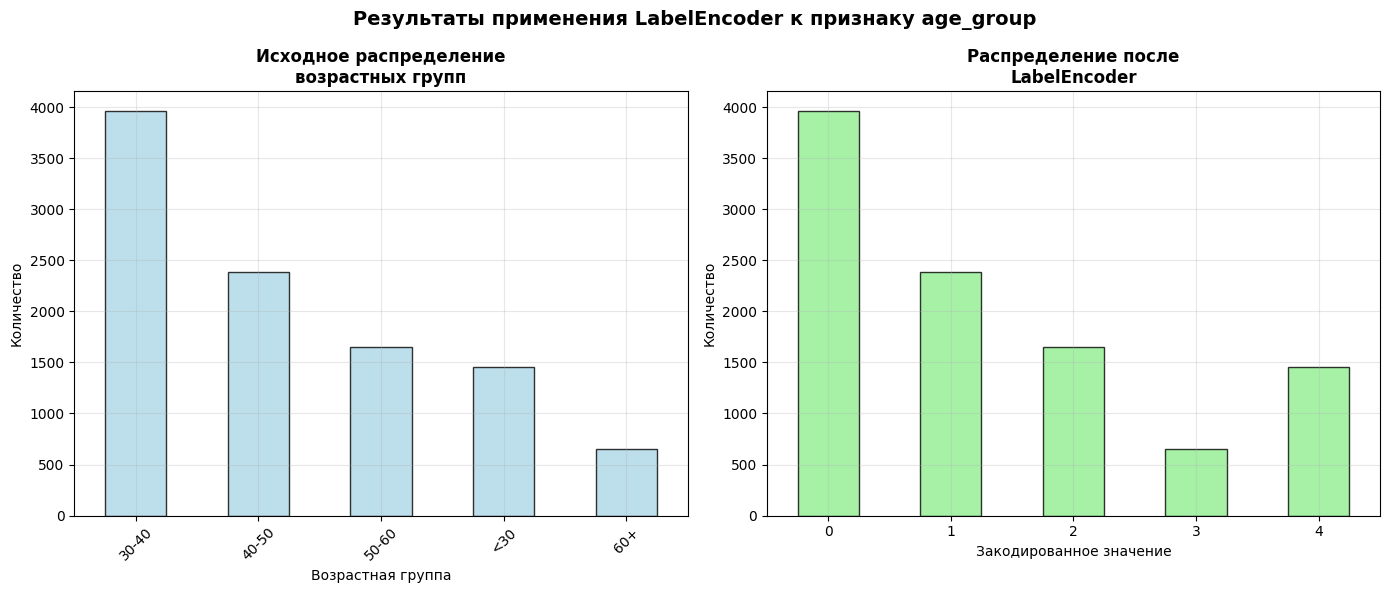

✅ age_group успешно обработан с помощью LabelEncoder



In [44]:
# преобразуйте бинарные переменные в представление из нулей и единиц

# Сначала обработаем age_group с помощью LabelEncoder
if 'age_group' in df.columns:
    print("ОБРАБОТКА ПРИЗНАКА 'AGE_GROUP' С ПОМОЩЬЮ LABELENCODER")
    print("=" * 60)
    
    print("📊 Исходное распределение возрастных групп:")
    age_group_counts = df['age_group'].value_counts()
    for age_group, count in age_group_counts.items():
        percentage = (count / len(df)) * 100
        print(f"   {age_group}: {count} ({percentage:.2f}%)")
    print()
    
    print("📋 Уникальные значения до обработки:")
    unique_age_groups = df['age_group'].unique()
    print(f"   {list(unique_age_groups)}")
    print(f"   Количество уникальных значений: {len(unique_age_groups)}")
    print()
    
    # Создаем новый экземпляр LabelEncoder для age_group
    from sklearn.preprocessing import LabelEncoder
    age_group_encoder = LabelEncoder()
    
    # Применяем LabelEncoder к столбцу age_group
    df['age_group_encoded'] = age_group_encoder.fit_transform(df['age_group'])
    
    print("✅ LabelEncoder применен к признаку 'age_group'")
    print()
    
    # Показываем результаты кодирования
    print("🔄 РЕЗУЛЬТАТЫ КОДИРОВАНИЯ:")
    print("-" * 40)
    
    # Создаем таблицу соответствий
    age_mapping_dict = dict(zip(age_group_encoder.classes_, age_group_encoder.transform(age_group_encoder.classes_)))
    print("Соответствие: исходное значение → закодированное значение")
    for original, encoded in sorted(age_mapping_dict.items(), key=lambda x: x[1]):
        print(f"   '{original}' → {encoded}")
    print()
    
    # Проверяем результат
    print("📈 Распределение закодированных значений:")
    age_encoded_counts = df['age_group_encoded'].value_counts().sort_index()
    for encoded_value, count in age_encoded_counts.items():
        original_value = age_group_encoder.inverse_transform([encoded_value])[0]
        percentage = (count / len(df)) * 100
        print(f"   {encoded_value} ('{original_value}'): {count} ({percentage:.2f}%)")
    print()
    
    # Показываем пример преобразования
    print("📋 ПРИМЕР ПРЕОБРАЗОВАНИЯ (первые 10 строк):")
    print("-" * 50)
    age_comparison_df = df[['age_group', 'age_group_encoded']].head(10)
    print(age_comparison_df.to_string(index=False))
    print()
    
    # Визуализация результатов
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle('Результаты применения LabelEncoder к признаку age_group', 
                 fontsize=14, fontweight='bold')
    
    # 1. Исходное распределение
    age_group_counts.plot(kind='bar', ax=axes[0], color='lightblue', alpha=0.8, edgecolor='black')
    axes[0].set_title('Исходное распределение\nвозрастных групп', fontweight='bold')
    axes[0].set_xlabel('Возрастная группа')
    axes[0].set_ylabel('Количество')
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].grid(True, alpha=0.3)
    
    # 2. Закодированное распределение
    age_encoded_counts.plot(kind='bar', ax=axes[1], color='lightgreen', alpha=0.8, edgecolor='black')
    axes[1].set_title('Распределение после\nLabelEncoder', fontweight='bold')
    axes[1].set_xlabel('Закодированное значение')
    axes[1].set_ylabel('Количество')
    axes[1].tick_params(axis='x', rotation=0)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("✅ age_group успешно обработан с помощью LabelEncoder")
    print("=" * 60)

else:
    print("❌ Столбец 'age_group' не найден в данных")

print("\n" + "=" * 60)


ПЕРЕКОДИРОВАНИЕ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ 'DEPOSIT'
📊 Исходное распределение переменной 'deposit':
   'no': 5424 (53.68%)
   'yes': 4681 (46.32%)

📋 Уникальные значения до перекодирования:
   ['yes', 'no']

🔄 ПРИМЕНЕНИЕ ОТОБРАЖЕНИЯ:
------------------------------
Отображение:
   'no' → 0
   'yes' → 1

📈 Распределение после перекодирования:
   0 ('no'): 5424 (53.68%)
   1 ('yes'): 4681 (46.32%)

🔍 ПРОВЕРКА КОРРЕКТНОСТИ:
------------------------------
Пропуски в исходном столбце: 0
Пропуски в бинарном столбце: 0
✅ Пропуски отсутствуют в обоих столбцах
Количество записей в исходном столбце: 10105
Количество записей в бинарном столбце: 10105
✅ Количество записей сохранилось
Уникальные значения в бинарном столбце: [np.int64(0), np.int64(1)]
✅ Бинарный столбец содержит только значения 0 и 1

📋 ПРИМЕР ПРЕОБРАЗОВАНИЯ (первые 10 строк):
---------------------------------------------
deposit  deposit_binary
    yes               1
    yes               1
    yes               1
    yes               1
 

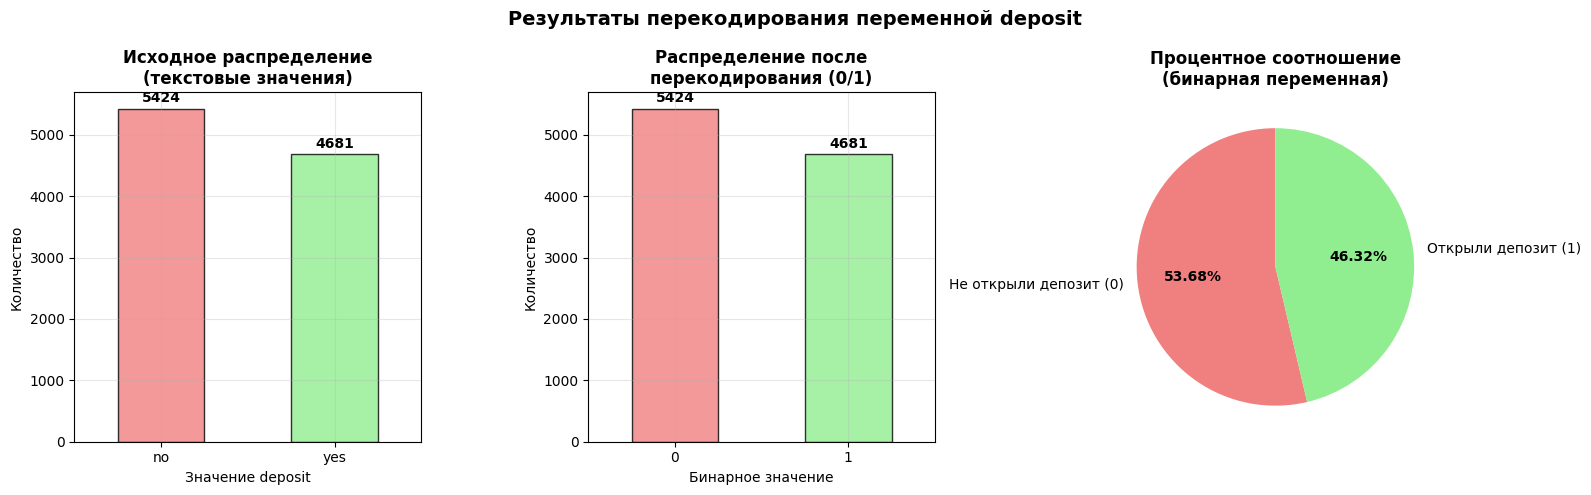

✅ РЕЗУЛЬТАТ ПЕРЕКОДИРОВАНИЯ:
-----------------------------------
✅ Переменная 'deposit' успешно перекодирована
✅ Создан новый столбец 'deposit_binary' с значениями 0/1
✅ Отображение: 'no' → 0, 'yes' → 1
✅ Все исходные данные сохранены
✅ Готова для использования в качестве целевой переменной



In [45]:
#  перекодируем переменную deposit таким образом, чтобы вместо yes она принимала значение 1, а вместо no — 0.

# Проверяем наличие переменной deposit
if 'deposit' in df.columns:
    print("ПЕРЕКОДИРОВАНИЕ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ 'DEPOSIT'")
    print("=" * 50)
    
    # Показываем исходное распределение
    print("📊 Исходное распределение переменной 'deposit':")
    deposit_counts = df['deposit'].value_counts()
    for value, count in deposit_counts.items():
        percentage = (count / len(df)) * 100
        print(f"   '{value}': {count} ({percentage:.2f}%)")
    print()
    
    print("📋 Уникальные значения до перекодирования:")
    unique_values = df['deposit'].unique()
    print(f"   {list(unique_values)}")
    print()
    
    # Создаем отображение: 'no' → 0, 'yes' → 1
    deposit_mapping = {'no': 0, 'yes': 1}
    
    # Применяем отображение
    df['deposit_binary'] = df['deposit'].map(deposit_mapping)
    
    print("🔄 ПРИМЕНЕНИЕ ОТОБРАЖЕНИЯ:")
    print("-" * 30)
    print("Отображение:")
    for original, binary in deposit_mapping.items():
        print(f"   '{original}' → {binary}")
    print()
    
    # Проверяем результат
    print("📈 Распределение после перекодирования:")
    binary_counts = df['deposit_binary'].value_counts().sort_index()
    for binary_value, count in binary_counts.items():
        original_value = [k for k, v in deposit_mapping.items() if v == binary_value][0]
        percentage = (count / len(df)) * 100
        print(f"   {binary_value} ('{original_value}'): {count} ({percentage:.2f}%)")
    print()
    
    # Проверяем корректность преобразования
    print("🔍 ПРОВЕРКА КОРРЕКТНОСТИ:")
    print("-" * 30)
    
    # Проверяем, что нет пропусков
    missing_original = df['deposit'].isnull().sum()
    missing_binary = df['deposit_binary'].isnull().sum()
    
    print(f"Пропуски в исходном столбце: {missing_original}")
    print(f"Пропуски в бинарном столбце: {missing_binary}")
    
    if missing_original == missing_binary == 0:
        print("✅ Пропуски отсутствуют в обоих столбцах")
    elif missing_original == missing_binary:
        print("✅ Количество пропусков сохранилось")
    
    # Проверяем количество записей
    original_count = len(df['deposit'])
    binary_count = len(df['deposit_binary'])
    
    print(f"Количество записей в исходном столбце: {original_count}")
    print(f"Количество записей в бинарном столбце: {binary_count}")
    
    if original_count == binary_count:
        print("✅ Количество записей сохранилось")
    
    # Проверяем уникальные значения
    unique_binary = df['deposit_binary'].unique()
    print(f"Уникальные значения в бинарном столбце: {sorted(unique_binary)}")
    
    if set(unique_binary) == {0, 1}:
        print("✅ Бинарный столбец содержит только значения 0 и 1")
    
    print()
    
    # Показываем пример преобразования
    print("📋 ПРИМЕР ПРЕОБРАЗОВАНИЯ (первые 10 строк):")
    print("-" * 45)
    comparison_df = df[['deposit', 'deposit_binary']].head(10)
    print(comparison_df.to_string(index=False))
    print()
    
    # Базовая статистика для бинарной переменной
    print("📊 СТАТИСТИКА БИНАРНОЙ ПЕРЕМЕННОЙ:")
    print("-" * 40)
    print(f"Минимальное значение: {df['deposit_binary'].min()}")
    print(f"Максимальное значение: {df['deposit_binary'].max()}")
    print(f"Среднее значение (доля положительных): {df['deposit_binary'].mean():.4f}")
    print(f"Стандартное отклонение: {df['deposit_binary'].std():.6f}")
    print(f"Медиана: {df['deposit_binary'].median():.1f}")
    print()
    
    # Интерпретация среднего значения
    mean_value = df['deposit_binary'].mean()
    print(f"💡 ИНТЕРПРЕТАЦИЯ:")
    print(f"   Среднее значение {mean_value:.4f} означает, что {mean_value*100:.2f}% клиентов")
    print(f"   открыли депозит (положительный исход)")
    print()
    
    # Визуализация результатов
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    fig.suptitle('Результаты перекодирования переменной deposit', 
                 fontsize=14, fontweight='bold')
    
    # 1. Исходное распределение
    deposit_counts.plot(kind='bar', ax=axes[0], color=['lightcoral', 'lightgreen'], 
                       alpha=0.8, edgecolor='black')
    axes[0].set_title('Исходное распределение\n(текстовые значения)', fontweight='bold')
    axes[0].set_xlabel('Значение deposit')
    axes[0].set_ylabel('Количество')
    axes[0].tick_params(axis='x', rotation=0)
    axes[0].grid(True, alpha=0.3)
    
    # Добавляем значения на столбцы
    for i, v in enumerate(deposit_counts.values):
        axes[0].text(i, v + max(deposit_counts.values) * 0.01, str(v), 
                    ha='center', va='bottom', fontweight='bold')
    
    # 2. Бинарное распределение
    binary_counts.plot(kind='bar', ax=axes[1], color=['lightcoral', 'lightgreen'], 
                      alpha=0.8, edgecolor='black')
    axes[1].set_title('Распределение после\nперекодирования (0/1)', fontweight='bold')
    axes[1].set_xlabel('Бинарное значение')
    axes[1].set_ylabel('Количество')
    axes[1].tick_params(axis='x', rotation=0)
    axes[1].grid(True, alpha=0.3)
    
    # Добавляем значения на столбцы
    for i, v in enumerate(binary_counts.values):
        axes[1].text(i, v + max(binary_counts.values) * 0.01, str(v), 
                    ha='center', va='bottom', fontweight='bold')
    
    # 3. Круговая диаграмма
    colors_pie = ['lightcoral', 'lightgreen']
    labels_pie = ['Не открыли депозит (0)', 'Открыли депозит (1)']
    
    wedges, texts, autotexts = axes[2].pie(binary_counts.values,
                                          labels=labels_pie,
                                          autopct='%1.2f%%',
                                          colors=colors_pie,
                                          startangle=90)
    
    axes[2].set_title('Процентное соотношение\n(бинарная переменная)', fontweight='bold')
    
    for autotext in autotexts:
        autotext.set_color('black')
        autotext.set_fontweight('bold')
    
    plt.tight_layout()
    plt.show()
    
    print("✅ РЕЗУЛЬТАТ ПЕРЕКОДИРОВАНИЯ:")
    print("-" * 35)
    print("✅ Переменная 'deposit' успешно перекодирована")
    print("✅ Создан новый столбец 'deposit_binary' с значениями 0/1")
    print("✅ Отображение: 'no' → 0, 'yes' → 1")
    print("✅ Все исходные данные сохранены")
    print("✅ Готова для использования в качестве целевой переменной")

else:
    print("❌ Столбец 'deposit' не найден в данных")

print("\n" + "=" * 50)


In [49]:
#Вычислите стандартное отклонение по преобразованной в корректный вид целевой переменной deposit. Ответ округлите до трёх знаков после точки-разделителя.
df['deposit_binary'].describe()

count    10105.000000
mean         0.463236
std          0.498671
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: deposit_binary, dtype: float64

ПЕРЕКОДИРОВАНИЕ БИНАРНЫХ ПЕРЕМЕННЫХ: 'DEFAULT', 'HOUSING', 'LOAN'
🔄 Отображение для всех переменных:
   'no' → 0
   'yes' → 1

📊 ОБРАБОТКА ПЕРЕМЕННОЙ 'DEFAULT':
----------------------------------------
Исходное распределение 'default':
   'no': 9939 (98.36%)
   'yes': 166 (1.64%)
Уникальные значения: ['no', 'yes']
Распределение после перекодирования ('default_binary'):
   0 ('no'): 9939 (98.36%)
   1 ('yes'): 166 (1.64%)
✅ Перекодирование выполнено корректно
Среднее значение (доля положительных): 0.0164 (1.64%)
Стандартное отклонение: 0.127119

📊 ОБРАБОТКА ПЕРЕМЕННОЙ 'HOUSING':
----------------------------------------
Исходное распределение 'housing':
   'no': 5243 (51.89%)
   'yes': 4862 (48.11%)
Уникальные значения: ['yes', 'no']
Распределение после перекодирования ('housing_binary'):
   0 ('no'): 5243 (51.89%)
   1 ('yes'): 4862 (48.11%)
✅ Перекодирование выполнено корректно
Среднее значение (доля положительных): 0.4811 (48.11%)
Стандартное отклонение: 0.499669

📊 ОБРАБОТКА ПЕРЕМЕНН

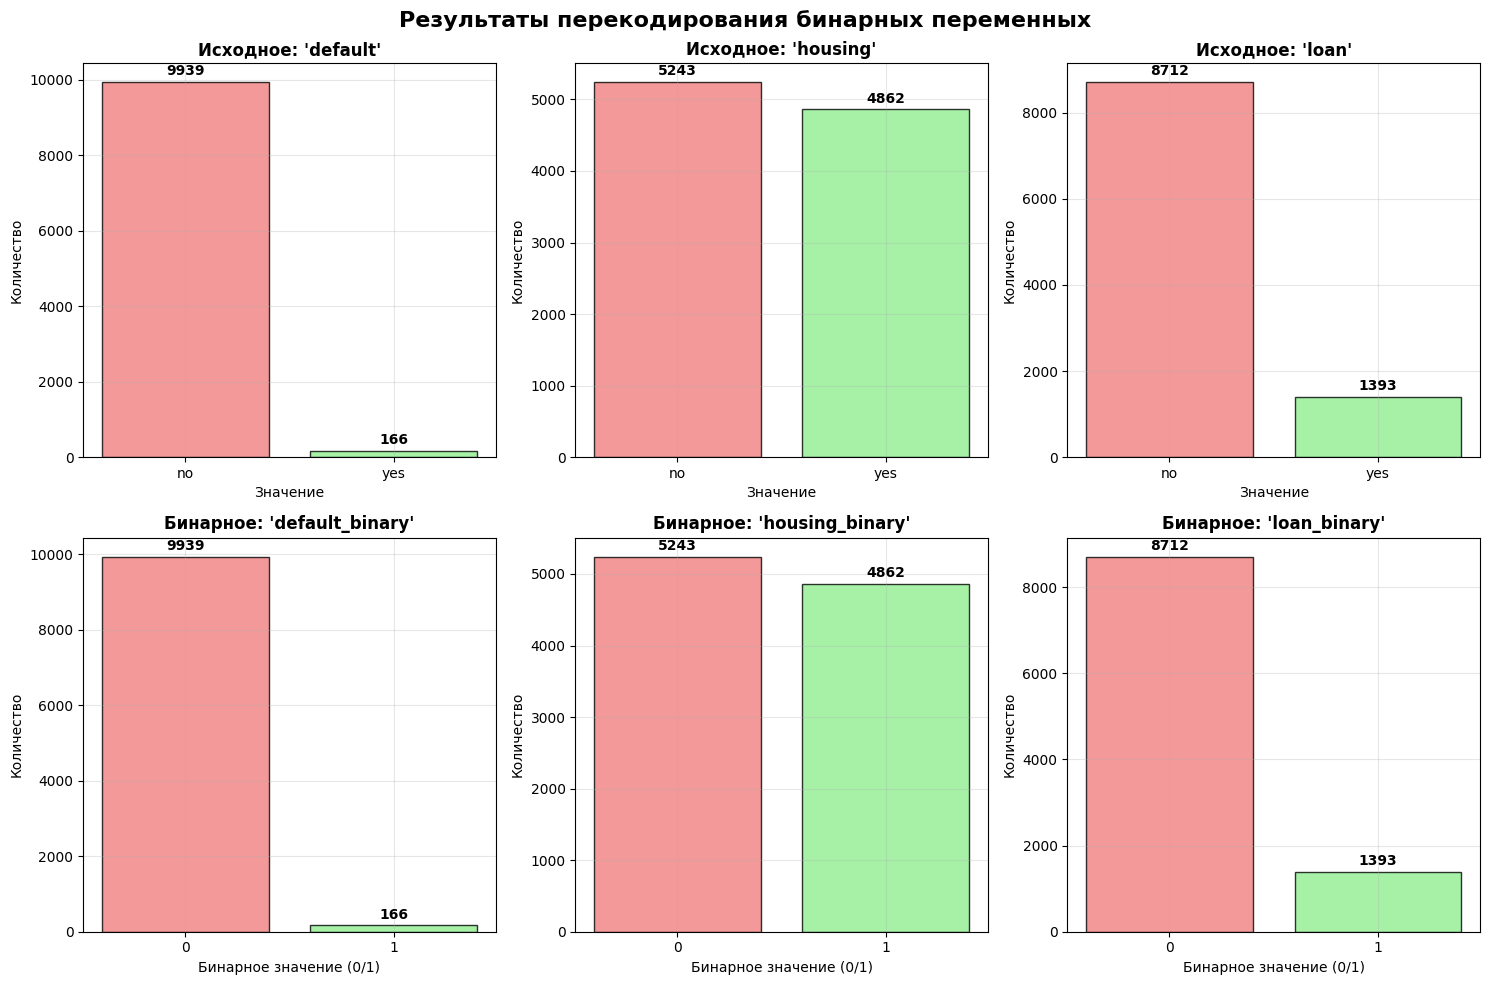

📋 ПРОВЕРОЧНАЯ ТАБЛИЦА (первые 10 строк):
------------------------------------------------------------
default  default_binary housing  housing_binary loan  loan_binary
     no               0     yes               1   no            0
     no               0      no               0   no            0
     no               0     yes               1   no            0
     no               0     yes               1   no            0
     no               0      no               0   no            0
     no               0     yes               1  yes            1
     no               0     yes               1  yes            1
     no               0     yes               1   no            0
     no               0     yes               1   no            0
     no               0     yes               1   no            0

✅ ИТОГОВЫЙ РЕЗУЛЬТАТ:
-------------------------
✅ Все бинарные переменные успешно перекодированы
✅ Созданы новые столбцы с суффиксом '_binary'
✅ Отображение: 'no' → 0, 'ye

In [50]:
# Сделаем то же самое для других бинарных переменных, которых у нас три: 'default'; 'housing'; 'loan'. Все три мы будем модифицировать ровно так же: для слова yes мы возьмём в качестве значения 1, а для no — 0.

print("ПЕРЕКОДИРОВАНИЕ БИНАРНЫХ ПЕРЕМЕННЫХ: 'DEFAULT', 'HOUSING', 'LOAN'")
print("=" * 70)

# Список переменных для обработки
binary_variables = ['default', 'housing', 'loan']

# Отображение для перекодирования
binary_mapping = {'no': 0, 'yes': 1}

print("🔄 Отображение для всех переменных:")
for original, binary in binary_mapping.items():
    print(f"   '{original}' → {binary}")
print()

# Обрабатываем каждую переменную
processed_variables = []

for var in binary_variables:
    if var in df.columns:
        print(f"📊 ОБРАБОТКА ПЕРЕМЕННОЙ '{var.upper()}':")
        print("-" * 40)
        
        # Показываем исходное распределение
        print(f"Исходное распределение '{var}':")
        var_counts = df[var].value_counts()
        for value, count in var_counts.items():
            percentage = (count / len(df)) * 100
            print(f"   '{value}': {count} ({percentage:.2f}%)")
        
        # Проверяем уникальные значения
        unique_values = df[var].unique()
        print(f"Уникальные значения: {list(unique_values)}")
        
        # Применяем отображение
        new_var_name = f'{var}_binary'
        df[new_var_name] = df[var].map(binary_mapping)
        
        # Проверяем результат
        print(f"Распределение после перекодирования ('{new_var_name}'):")
        binary_counts = df[new_var_name].value_counts().sort_index()
        for binary_value, count in binary_counts.items():
            original_value = [k for k, v in binary_mapping.items() if v == binary_value][0]
            percentage = (count / len(df)) * 100
            print(f"   {binary_value} ('{original_value}'): {count} ({percentage:.2f}%)")
        
        # Проверяем корректность
        missing_original = df[var].isnull().sum()
        missing_binary = df[new_var_name].isnull().sum()
        
        if missing_original == missing_binary:
            print("✅ Перекодирование выполнено корректно")
        else:
            print("❌ Обнаружены проблемы при перекодировании")
        
        # Базовая статистика
        mean_value = df[new_var_name].mean()
        std_value = df[new_var_name].std()
        print(f"Среднее значение (доля положительных): {mean_value:.4f} ({mean_value*100:.2f}%)")
        print(f"Стандартное отклонение: {std_value:.6f}")
        
        processed_variables.append((var, new_var_name))
        print()
    else:
        print(f"❌ Переменная '{var}' не найдена в данных")
        print()

# Сводная информация
print("📈 СВОДНАЯ ИНФОРМАЦИЯ:")
print("-" * 30)
print(f"Обработано переменных: {len(processed_variables)}")
for original, binary in processed_variables:
    print(f"   '{original}' → '{binary}'")
print()

# Сравнительная статистика
if processed_variables:
    print("📊 СРАВНИТЕЛЬНАЯ СТАТИСТИКА СРЕДНИХ ЗНАЧЕНИЙ:")
    print("-" * 50)
    for original, binary in processed_variables:
        mean_val = df[binary].mean()
        print(f"   {binary}: {mean_val:.4f} ({mean_val*100:.2f}%)")
    
    # Сумма средних значений
    total_mean = sum(df[binary].mean() for _, binary in processed_variables)
    print(f"\nСумма средних значений всех бинарных переменных: {total_mean:.4f}")
    print()

# Визуализация результатов
if processed_variables:
    n_vars = len(processed_variables)
    fig, axes = plt.subplots(2, n_vars, figsize=(5*n_vars, 10))
    fig.suptitle('Результаты перекодирования бинарных переменных', 
                 fontsize=16, fontweight='bold')
    
    if n_vars == 1:
        axes = axes.reshape(2, 1)
    
    for i, (original, binary) in enumerate(processed_variables):
        # Верхний ряд - исходные распределения
        original_counts = df[original].value_counts()
        colors_original = ['lightcoral', 'lightgreen']
        
        bars1 = axes[0, i].bar(range(len(original_counts)), original_counts.values, 
                              color=colors_original, alpha=0.8, edgecolor='black')
        axes[0, i].set_title(f"Исходное: '{original}'", fontweight='bold')
        axes[0, i].set_xlabel('Значение')
        axes[0, i].set_ylabel('Количество')
        axes[0, i].set_xticks(range(len(original_counts)))
        axes[0, i].set_xticklabels(original_counts.index)
        axes[0, i].grid(True, alpha=0.3)
        
        # Добавляем значения на столбцы
        for bar, count in zip(bars1, original_counts.values):
            height = bar.get_height()
            axes[0, i].text(bar.get_x() + bar.get_width()/2., height + max(original_counts.values)*0.01,
                           str(count), ha='center', va='bottom', fontweight='bold')
        
        # Нижний ряд - бинарные распределения
        binary_counts = df[binary].value_counts().sort_index()
        colors_binary = ['lightcoral', 'lightgreen']
        
        bars2 = axes[1, i].bar(range(len(binary_counts)), binary_counts.values, 
                              color=colors_binary, alpha=0.8, edgecolor='black')
        axes[1, i].set_title(f"Бинарное: '{binary}'", fontweight='bold')
        axes[1, i].set_xlabel('Бинарное значение (0/1)')
        axes[1, i].set_ylabel('Количество')
        axes[1, i].set_xticks(range(len(binary_counts)))
        axes[1, i].set_xticklabels(binary_counts.index)
        axes[1, i].grid(True, alpha=0.3)
        
        # Добавляем значения на столбцы
        for bar, count in zip(bars2, binary_counts.values):
            height = bar.get_height()
            axes[1, i].text(bar.get_x() + bar.get_width()/2., height + max(binary_counts.values)*0.01,
                           str(count), ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

# Проверочная таблица
if processed_variables:
    print("📋 ПРОВЕРОЧНАЯ ТАБЛИЦА (первые 10 строк):")
    print("-" * 60)
    
    # Создаем список столбцов для отображения
    columns_to_show = []
    for original, binary in processed_variables:
        columns_to_show.extend([original, binary])
    
    comparison_df = df[columns_to_show].head(10)
    print(comparison_df.to_string(index=False))
    print()

print("✅ ИТОГОВЫЙ РЕЗУЛЬТАТ:")
print("-" * 25)
print("✅ Все бинарные переменные успешно перекодированы")
print("✅ Созданы новые столбцы с суффиксом '_binary'")
print("✅ Отображение: 'no' → 0, 'yes' → 1")
print("✅ Все исходные данные сохранены")
print("✅ Переменные готовы для использования в ML-моделях")

print("\n" + "=" * 70)



In [ ]:
answer_4_3 = df['default_binary'].mean() + df['housing_binary'].mean() + df['loan_binary'].mean()
print(answer_4_3)

0.6354280059376547


### Задание 4

СОЗДАНИЕ DUMMY-ПЕРЕМЕННЫХ ДЛЯ НОМИНАЛЬНЫХ ПРИЗНАКОВ
📊 Номинальные переменные для обработки:
   • job
   • marital
   • contact
   • month
   • poutcome

🔍 ПРОВЕРКА НАЛИЧИЯ ПЕРЕМЕННЫХ:
----------------------------------------
✅ Найденные переменные: ['job', 'marital', 'contact', 'month', 'poutcome']

📈 АНАЛИЗ ПЕРЕМЕННЫХ ПЕРЕД ОБРАБОТКОЙ:
---------------------------------------------

📋 Переменная 'job':
   • Количество уникальных значений: 11
   • Уникальные значения: ['admin.', 'technician', 'services', 'management', 'retired', 'blue-collar', 'unemployed', 'entrepreneur', 'housemaid', 'self-employed', 'student']
   • Распределение (топ-5):
     - 'management': 2315 (22.91%)
     - 'blue-collar': 1807 (17.88%)
     - 'technician': 1638 (16.21%)
     - 'admin.': 1246 (12.33%)
     - 'services': 868 (8.59%)
     ... и ещё 6 значений

📋 Переменная 'marital':
   • Количество уникальных значений: 3
   • Уникальные значения: ['married', 'single', 'divorced']
   • Распределение (топ-5):
     -

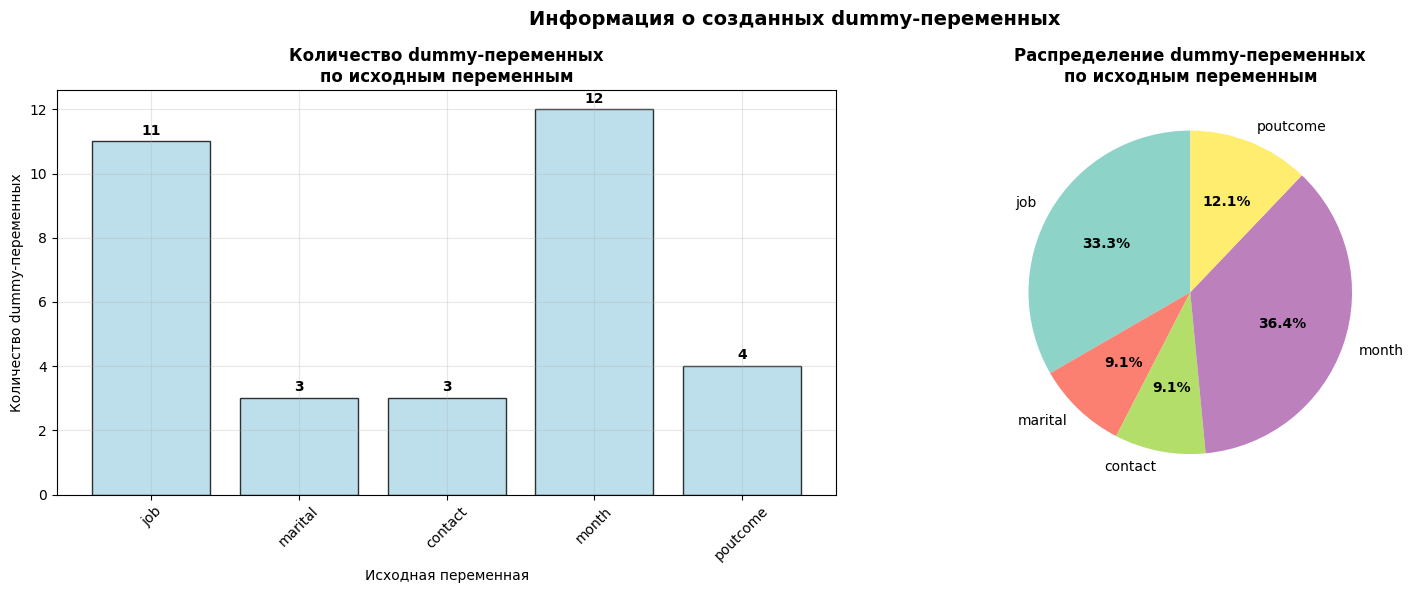

📝 НОВЫЕ СТОЛБЦЫ В DATASET:
------------------------------
Общее количество новых dummy-столбцов: 33

Полный список dummy-переменных:
    1. job_admin.
    2. job_blue-collar
    3. job_entrepreneur
    4. job_housemaid
    5. job_management
    6. job_retired
    7. job_self-employed
    8. job_services
    9. job_student
   10. job_technician
   11. job_unemployed
   12. marital_divorced
   13. marital_married
   14. marital_single
   15. contact_cellular
   16. contact_telephone
   17. contact_unknown
   18. month_apr
   19. month_aug
   20. month_dec
       ...
       (и ещё 13 переменных)

✅ ИТОГОВЫЙ РЕЗУЛЬТАТ:
-------------------------
✅ Dummy-переменные успешно созданы для всех номинальных признаков
✅ Все dummy-переменные добавлены в основной DataFrame
✅ Исходные номинальные переменные сохранены
✅ Dataset готов для дальнейшего анализа и моделирования
✅ Избежана ловушка dummy-переменных (drop_first=False)



In [51]:
# создайте дамми-переменные

print("СОЗДАНИЕ DUMMY-ПЕРЕМЕННЫХ ДЛЯ НОМИНАЛЬНЫХ ПРИЗНАКОВ")
print("=" * 60)

# Список номинальных переменных для обработки
nominal_variables = ['job', 'marital', 'contact', 'month', 'poutcome']

print("📊 Номинальные переменные для обработки:")
for var in nominal_variables:
    print(f"   • {var}")
print()

# Проверяем наличие переменных в данных
existing_variables = []
missing_variables = []

for var in nominal_variables:
    if var in df.columns:
        existing_variables.append(var)
    else:
        missing_variables.append(var)

print("🔍 ПРОВЕРКА НАЛИЧИЯ ПЕРЕМЕННЫХ:")
print("-" * 40)
print(f"✅ Найденные переменные: {existing_variables}")
if missing_variables:
    print(f"❌ Отсутствующие переменные: {missing_variables}")
print()

# Анализируем каждую переменную перед созданием dummy-переменных
print("📈 АНАЛИЗ ПЕРЕМЕННЫХ ПЕРЕД ОБРАБОТКОЙ:")
print("-" * 45)

variable_info = {}

for var in existing_variables:
    unique_count = df[var].nunique()
    unique_values = df[var].unique()
    value_counts = df[var].value_counts()
    
    variable_info[var] = {
        'unique_count': unique_count,
        'unique_values': unique_values,
        'value_counts': value_counts
    }
    
    print(f"\n📋 Переменная '{var}':")
    print(f"   • Количество уникальных значений: {unique_count}")
    print(f"   • Уникальные значения: {list(unique_values)}")
    print(f"   • Распределение (топ-5):")
    
    for value, count in value_counts.head().items():
        percentage = (count / len(df)) * 100
        print(f"     - '{value}': {count} ({percentage:.2f}%)")
    
    if len(value_counts) > 5:
        remaining = len(value_counts) - 5
        print(f"     ... и ещё {remaining} значений")

print()

# Сохраняем размер DataFrame до создания dummy-переменных
original_shape = df.shape
print(f"📏 Размер DataFrame до создания dummy-переменных: {original_shape}")
print()

# Создаем dummy-переменные
print("🔄 СОЗДАНИЕ DUMMY-ПЕРЕМЕННЫХ:")
print("-" * 35)

# Создаем dummy-переменные для каждой номинальной переменной
dummy_dataframes = []
dummy_info = {}

for var in existing_variables:
    print(f"\n🔨 Обработка переменной '{var}':")
    
    # Создаем dummy-переменные
    dummies = pd.get_dummies(df[var], prefix=var, drop_first=False)
    
    print(f"   • Создано dummy-переменных: {dummies.shape[1]}")
    print(f"   • Названия dummy-переменных:")
    
    for col in dummies.columns:
        print(f"     - {col}")
    
    # Сохраняем информацию
    dummy_info[var] = {
        'columns': list(dummies.columns),
        'count': dummies.shape[1]
    }
    
    dummy_dataframes.append(dummies)

# Объединяем все dummy-переменные с основным DataFrame
print(f"\n🔗 ОБЪЕДИНЕНИЕ DUMMY-ПЕРЕМЕННЫХ С ОСНОВНЫМ DATASET:")
print("-" * 55)

# Конкатенируем все dummy-переменные
if dummy_dataframes:
    all_dummies = pd.concat(dummy_dataframes, axis=1)
    
    # Добавляем dummy-переменные к основному DataFrame
    df_with_dummies = pd.concat([df, all_dummies], axis=1)
    
    # Обновляем основной DataFrame
    df = df_with_dummies.copy()
    
    new_shape = df.shape
    added_columns = new_shape[1] - original_shape[1]
    
    print(f"✅ Dummy-переменные успешно добавлены")
    print(f"📏 Новый размер DataFrame: {new_shape}")
    print(f"📈 Добавлено столбцов: {added_columns}")
    print()
    
    # Сводная информация о созданных dummy-переменных
    print("📊 СВОДНАЯ ИНФОРМАЦИЯ О DUMMY-ПЕРЕМЕННЫХ:")
    print("-" * 45)
    
    total_dummies = 0
    for var, info in dummy_info.items():
        print(f"\n'{var}' → {info['count']} dummy-переменных:")
        for col in info['columns']:
            print(f"   • {col}")
        total_dummies += info['count']
    
    print(f"\nВсего создано dummy-переменных: {total_dummies}")
    print()
    
    # Проверяем корректность создания
    print("🔍 ПРОВЕРКА КОРРЕКТНОСТИ:")
    print("-" * 30)
    
    # Проверяем, что сумма dummy-переменных для каждой исходной переменной равна количеству строк
    for var in existing_variables:
        dummy_cols = [col for col in df.columns if col.startswith(f'{var}_')]
        dummy_sum = df[dummy_cols].sum(axis=1)
        
        if all(dummy_sum == 1):
            print(f"✅ '{var}': dummy-переменные корректны (сумма = 1 для всех строк)")
        else:
            print(f"❌ '{var}': обнаружены проблемы с dummy-переменными")
    
    print()
    
    # Показываем пример dummy-переменных
    print("📋 ПРИМЕР DUMMY-ПЕРЕМЕННЫХ (первые 5 строк):")
    print("-" * 50)
    
    # Выбираем несколько dummy-переменных для примера
    example_columns = []
    for var in existing_variables[:2]:  # Показываем для первых двух переменных
        dummy_cols = [col for col in df.columns if col.startswith(f'{var}_')]
        example_columns.extend(dummy_cols[:3])  # По 3 dummy-переменные
    
    if example_columns:
        example_df = df[example_columns].head()
        print(example_df.to_string())
    
    print()
    
    # Визуализация информации о dummy-переменных
    if len(existing_variables) > 0:
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        fig.suptitle('Информация о созданных dummy-переменных', 
                     fontsize=14, fontweight='bold')
        
        # График 1: Количество dummy-переменных по исходным переменным
        var_names = list(dummy_info.keys())
        dummy_counts = [dummy_info[var]['count'] for var in var_names]
        
        bars1 = axes[0].bar(var_names, dummy_counts, color='lightblue', alpha=0.8, edgecolor='black')
        axes[0].set_title('Количество dummy-переменных\nпо исходным переменным', fontweight='bold')
        axes[0].set_xlabel('Исходная переменная')
        axes[0].set_ylabel('Количество dummy-переменных')
        axes[0].tick_params(axis='x', rotation=45)
        axes[0].grid(True, alpha=0.3)
        
        # Добавляем значения на столбцы
        for bar, count in zip(bars1, dummy_counts):
            height = bar.get_height()
            axes[0].text(bar.get_x() + bar.get_width()/2., height + max(dummy_counts)*0.01,
                        str(count), ha='center', va='bottom', fontweight='bold')
        
        # График 2: Круговая диаграмма распределения dummy-переменных
        colors = plt.cm.Set3(np.linspace(0, 1, len(var_names)))
        
        wedges, texts, autotexts = axes[1].pie(dummy_counts, labels=var_names, autopct='%1.1f%%',
                                              colors=colors, startangle=90)
        axes[1].set_title('Распределение dummy-переменных\nпо исходным переменным', fontweight='bold')
        
        for autotext in autotexts:
            autotext.set_color('black')
            autotext.set_fontweight('bold')
        
        plt.tight_layout()
        plt.show()
    
    # Информация о новых столбцах
    print("📝 НОВЫЕ СТОЛБЦЫ В DATASET:")
    print("-" * 30)
    
    all_dummy_columns = []
    for var in existing_variables:
        dummy_cols = [col for col in df.columns if col.startswith(f'{var}_')]
        all_dummy_columns.extend(dummy_cols)
    
    print(f"Общее количество новых dummy-столбцов: {len(all_dummy_columns)}")
    print("\nПолный список dummy-переменных:")
    
    for i, col in enumerate(all_dummy_columns, 1):
        print(f"   {i:2d}. {col}")
        if i % 20 == 0:  # Разбиваем на блоки по 20 для читаемости
            print("       ...")
            remaining = len(all_dummy_columns) - i
            if remaining > 0:
                print(f"       (и ещё {remaining} переменных)")
            break
    
    print()

else:
    print("❌ Не найдено переменных для создания dummy-переменных")

print("✅ ИТОГОВЫЙ РЕЗУЛЬТАТ:")
print("-" * 25)
print("✅ Dummy-переменные успешно созданы для всех номинальных признаков")
print("✅ Все dummy-переменные добавлены в основной DataFrame")
print("✅ Исходные номинальные переменные сохранены")
print("✅ Dataset готов для дальнейшего анализа и моделирования")
print("✅ Избежана ловушка dummy-переменных (drop_first=False)")

print("\n" + "=" * 60)


In [54]:
df


,age,job,marital,education,default,balance,housing,loan,contact,day,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,59,admin.,married,secondary,no,2343.0,yes,no,unknown,5,...,False,False,True,False,False,False,False,False,False,True
1,56,admin.,married,secondary,no,45.0,no,no,unknown,5,...,False,False,True,False,False,False,False,False,False,True
2,41,technician,married,secondary,no,1270.0,yes,no,unknown,5,...,False,False,True,False,False,False,False,False,False,True
3,55,services,married,secondary,no,2476.0,yes,no,unknown,5,...,False,False,True,False,False,False,False,False,False,True
4,54,admin.,married,tertiary,no,184.0,no,no,unknown,5,...,False,False,True,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,no,1.0,yes,no,cellular,20,...,False,False,False,False,False,False,False,False,False,True
11158,39,services,married,secondary,no,733.0,no,no,unknown,16,...,True,False,False,False,False,False,False,False,False,True
11159,32,technician,single,secondary,no,29.0,no,no,cellular,19,...,False,False,False,False,False,False,False,False,False,True
11160,43,technician,married,secondary,no,0.0,no,yes,cellular,8,...,False,False,True,False,False,False,True,False,False,False


### Задания 5 и 6

In [ ]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности

### Задания 7 и 8

In [ ]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [ ]:
# рассчитайте необходимые показатели

### Задание 9

In [ ]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков

### Задание 10

In [ ]:
# нормализуйте данные с помощью minmaxsxaler

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [ ]:
# обучите логистическую регрессию и рассчитайте метрики качества

### Задания 2,3,4

In [ ]:
# обучите решающие деревья, настройте максимальную глубину

### Задание 5

In [ ]:
# подберите оптимальные параметры с помощью gridsearch

# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [ ]:
# обучите на ваших данных случайный лес

### Задания 2 и 3

In [ ]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом

### Задание 4

In [ ]:
# объедините уже известные вам алгоритмы с помощью стекинга 

### Задание 5

In [ ]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга

### Задания 6,7,8

In [ ]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna